In [167]:
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler

In [168]:
from matplotlib import font_manager, rc
import matplotlib
import platform

# 한글꺠짐 처리(windows, mac)
path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")
    
# 차트에 마이너스 부분이 깨질때 처리
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [169]:
import matplotlib.pyplot as plt
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당합니다.

# ggplot으로 그래프 스타일 설정
plt.style.use('ggplot')

# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# set_matplotlib_formats('png')
# set_matplotlib_formats('jpg')
# set_matplotlib_formats('svg')

### 데이터 불러오기

In [170]:
# train = pd.read_csv('./Data/train_df_errno2.csv')
# test = pd.read_csv('./Data/test_df2.csv')

train = pd.read_csv('./Data/train_df_errno_final.csv')
test = pd.read_csv('./Data/test_df_final.csv')

train_ml = pd.read_csv('./Data/train_df_errno_final(ML).csv')
test_ml = pd.read_csv('./Data/test_df_final(ML).csv')

age = pd.read_csv('./Data/age_gender_info.csv')

train.shape, test.shape, train_ml.shape, test_ml.shape

((2896, 23), (1008, 21), (2896, 23), (1008, 21))

In [171]:
# stat.molit.go.kr/portal/cate/statFileView.do?hRsId=58&hFormId=5409&hKeyWord=자동차등록&hTotalFlag=Y
car = pd.read_excel('./Data/2021년_06월_자동차_등록자료_통계.xlsx', 
                    sheet_name=3,
                    skiprows=2,
                    usecols=range(0, 20))
car.shape

(22, 20)

In [172]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,단지내주차면수,단지코드_Type,임대건물구분_lbl,지역_lbl,공급유형_lbl,자격유형_lbl,단지코드_lbl,qcut_총세대수,등록차량수,log_등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,...,624.0,3.0,1,1,1,1,492,1,205.0,5.327876


In [173]:
age.head()

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.088468,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.076636,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013


### 자동차 등록자료 결측치 및 데이터 전처리

In [174]:
car

,성별,연령/시도,총계,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주
0,남성,10대 이하,7437,1371,446,198,389,153,276,189,75,2140,181,267,277,294,280,184,564,153
1,NaN,20대,356992,34205,18101,16904,22269,12628,12114,8930,2209,97857,14409,16590,20507,14402,15546,20746,24485,5090
2,NaN,30대,2159536,302499,118012,101979,127869,63873,66700,53399,22189,629142,63712,77251,111205,67031,70872,112663,143393,27747
3,NaN,40대,3912264,508214,211040,189715,215684,117530,113270,99745,42365,1109019,118716,132873,197513,142332,145890,221831,286281,60246
4,NaN,50대,4417099,535067,225506,226919,231824,130177,129276,126736,31715,1138075,156776,167229,219242,183433,203100,300922,341419,69683
5,NaN,60대,3450897,433997,203219,172957,173957,84641,96344,97069,19851,788009,142611,141150,177831,152936,166940,272794,277696,48895
6,NaN,70대,1088779,158200,67062,55435,44577,26622,28079,23543,5163,217137,47229,42168,60042,55916,62158,94595,83319,17534
7,NaN,80대,193790,30506,10403,9524,6641,4423,4795,2808,837,41212,10213,7868,11054,10473,10352,16589,12406,3686
8,NaN,90대 이상,16671,3403,1012,746,627,382,384,222,65,3482,658,504,859,957,978,1165,971,256
9,NaN,계,15603465,2007462,854801,774377,823837,440429,451238,412641,124469,4026073,554505,585900,798530,627774,676116,1041489,1170534,233290


In [175]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   성별      4 non-null      object
 1   연령/시도   21 non-null     object
 2   총계      22 non-null     int64 
 3   서울      22 non-null     int64 
 4   부산      22 non-null     int64 
 5   대구      22 non-null     int64 
 6   인천      22 non-null     int64 
 7   광주      22 non-null     int64 
 8   대전      22 non-null     int64 
 9   울산      22 non-null     int64 
 10  세종      22 non-null     int64 
 11  경기      22 non-null     int64 
 12  강원      22 non-null     int64 
 13  충북      22 non-null     int64 
 14  충남      22 non-null     int64 
 15  전북      22 non-null     int64 
 16  전남      22 non-null     int64 
 17  경북      22 non-null     int64 
 18  경남      22 non-null     int64 
 19  제주      22 non-null     int64 
dtypes: int64(18), object(2)
memory usage: 3.6+ KB


In [176]:
car.isna().sum()

성별       18
연령/시도     1
총계        0
서울        0
부산        0
대구        0
인천        0
광주        0
대전        0
울산        0
세종        0
경기        0
강원        0
충북        0
충남        0
전북        0
전남        0
경북        0
경남        0
제주        0
dtype: int64

In [177]:
car.iloc[1:10, 0] = '남성'
car.iloc[11:20, 0] = '여성'
car.iloc[21, 1] = '합계'

In [178]:
car.isna().sum()

성별       0
연령/시도    0
총계       0
서울       0
부산       0
대구       0
인천       0
광주       0
대전       0
울산       0
세종       0
경기       0
강원       0
충북       0
충남       0
전북       0
전남       0
경북       0
경남       0
제주       0
dtype: int64

In [179]:
car.columns = ['성별', '연령', '총계', '서울특별시', '부산광역시', 
               '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
               '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도',
               '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']
car.columns

Index(['성별', '연령', '총계', '서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시',
       '울산광역시', '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도',
       '경상북도', '경상남도', '제주특별자치도'],
      dtype='object')

### 성별/연령별 자동차 등록대수 시각화

In [180]:
car

,성별,연령,총계,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,남성,10대 이하,7437,1371,446,198,389,153,276,189,75,2140,181,267,277,294,280,184,564,153
1,남성,20대,356992,34205,18101,16904,22269,12628,12114,8930,2209,97857,14409,16590,20507,14402,15546,20746,24485,5090
2,남성,30대,2159536,302499,118012,101979,127869,63873,66700,53399,22189,629142,63712,77251,111205,67031,70872,112663,143393,27747
3,남성,40대,3912264,508214,211040,189715,215684,117530,113270,99745,42365,1109019,118716,132873,197513,142332,145890,221831,286281,60246
4,남성,50대,4417099,535067,225506,226919,231824,130177,129276,126736,31715,1138075,156776,167229,219242,183433,203100,300922,341419,69683
5,남성,60대,3450897,433997,203219,172957,173957,84641,96344,97069,19851,788009,142611,141150,177831,152936,166940,272794,277696,48895
6,남성,70대,1088779,158200,67062,55435,44577,26622,28079,23543,5163,217137,47229,42168,60042,55916,62158,94595,83319,17534
7,남성,80대,193790,30506,10403,9524,6641,4423,4795,2808,837,41212,10213,7868,11054,10473,10352,16589,12406,3686
8,남성,90대 이상,16671,3403,1012,746,627,382,384,222,65,3482,658,504,859,957,978,1165,971,256
9,남성,계,15603465,2007462,854801,774377,823837,440429,451238,412641,124469,4026073,554505,585900,798530,627774,676116,1041489,1170534,233290


In [181]:
car['성별연령'] = car['성별'] + ' ' + car['연령']

In [182]:
grap_car = car.drop([9, 19, 20, 21])

In [183]:
grap_car.columns[3:-1]

Index(['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
       '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도',
       '제주특별자치도'],
      dtype='object')

Text(0, 0.5, '자동차 등록대수')

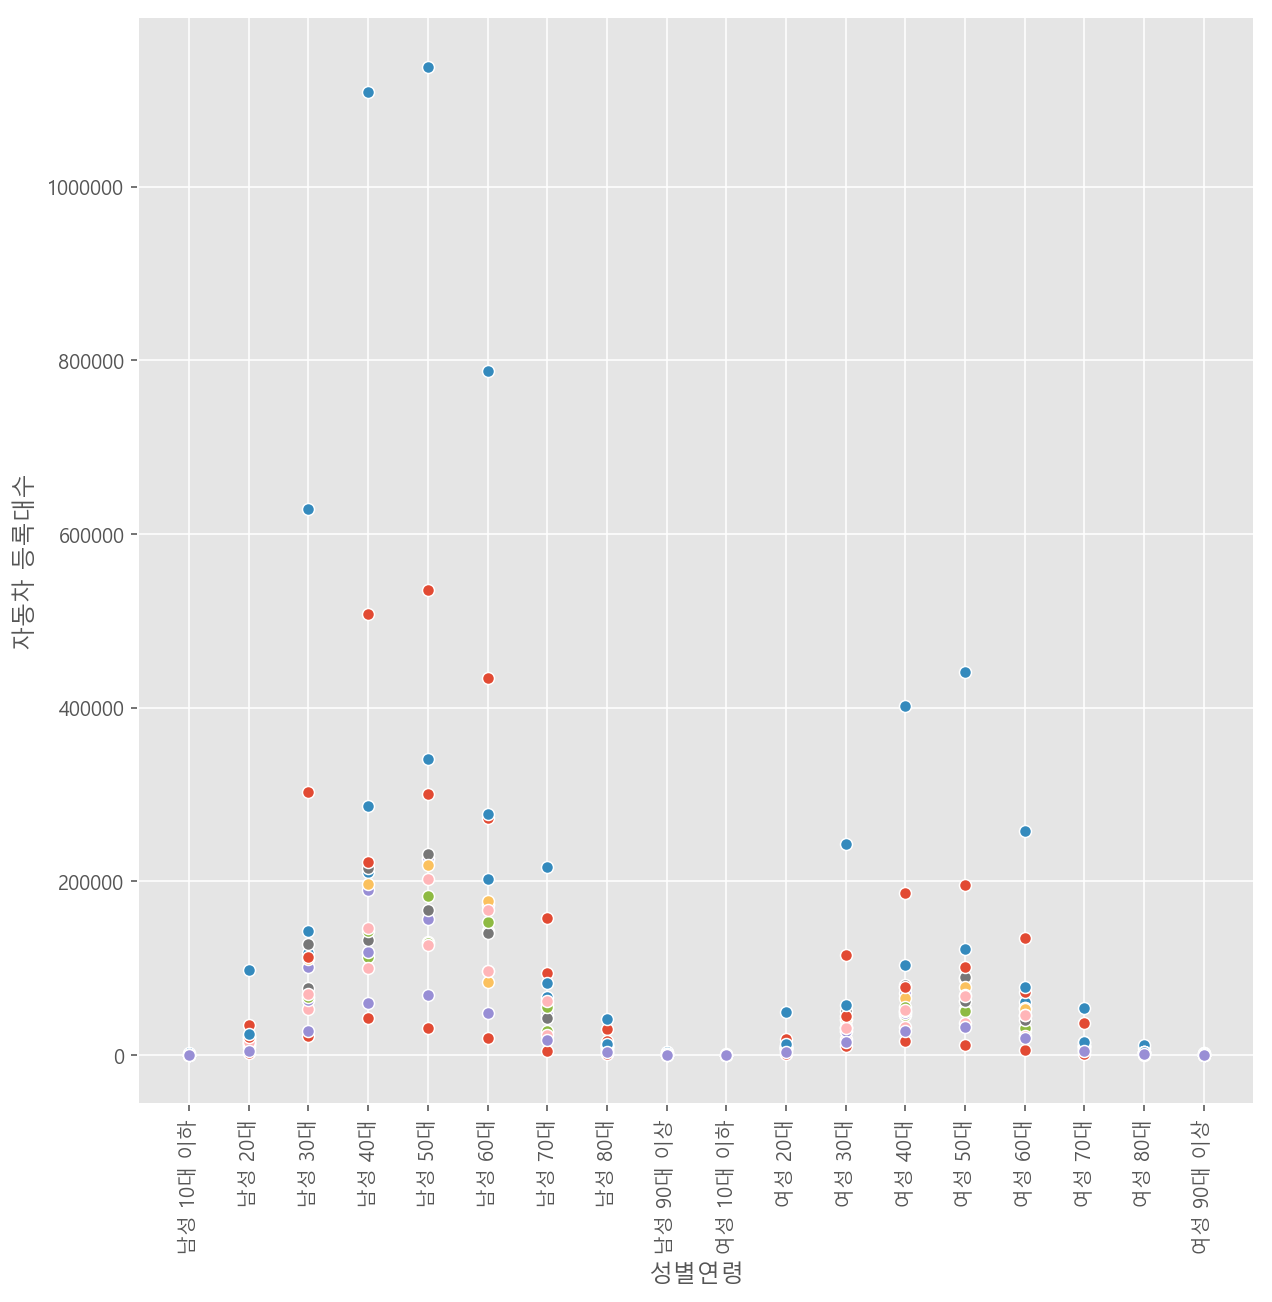

In [184]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation = 90 )

for i in grap_car.columns[3:-1] :
    sns.lineplot(x='성별연령', y=i, data=grap_car, marker='o', linestyle = "none", alpha=1)
    
plt.ylabel("자동차 등록대수")

In [185]:
grouped = grap_car.groupby('연령')

group = grouped.sum()

Text(0, 0.5, '남녀 자동차 등록대수')

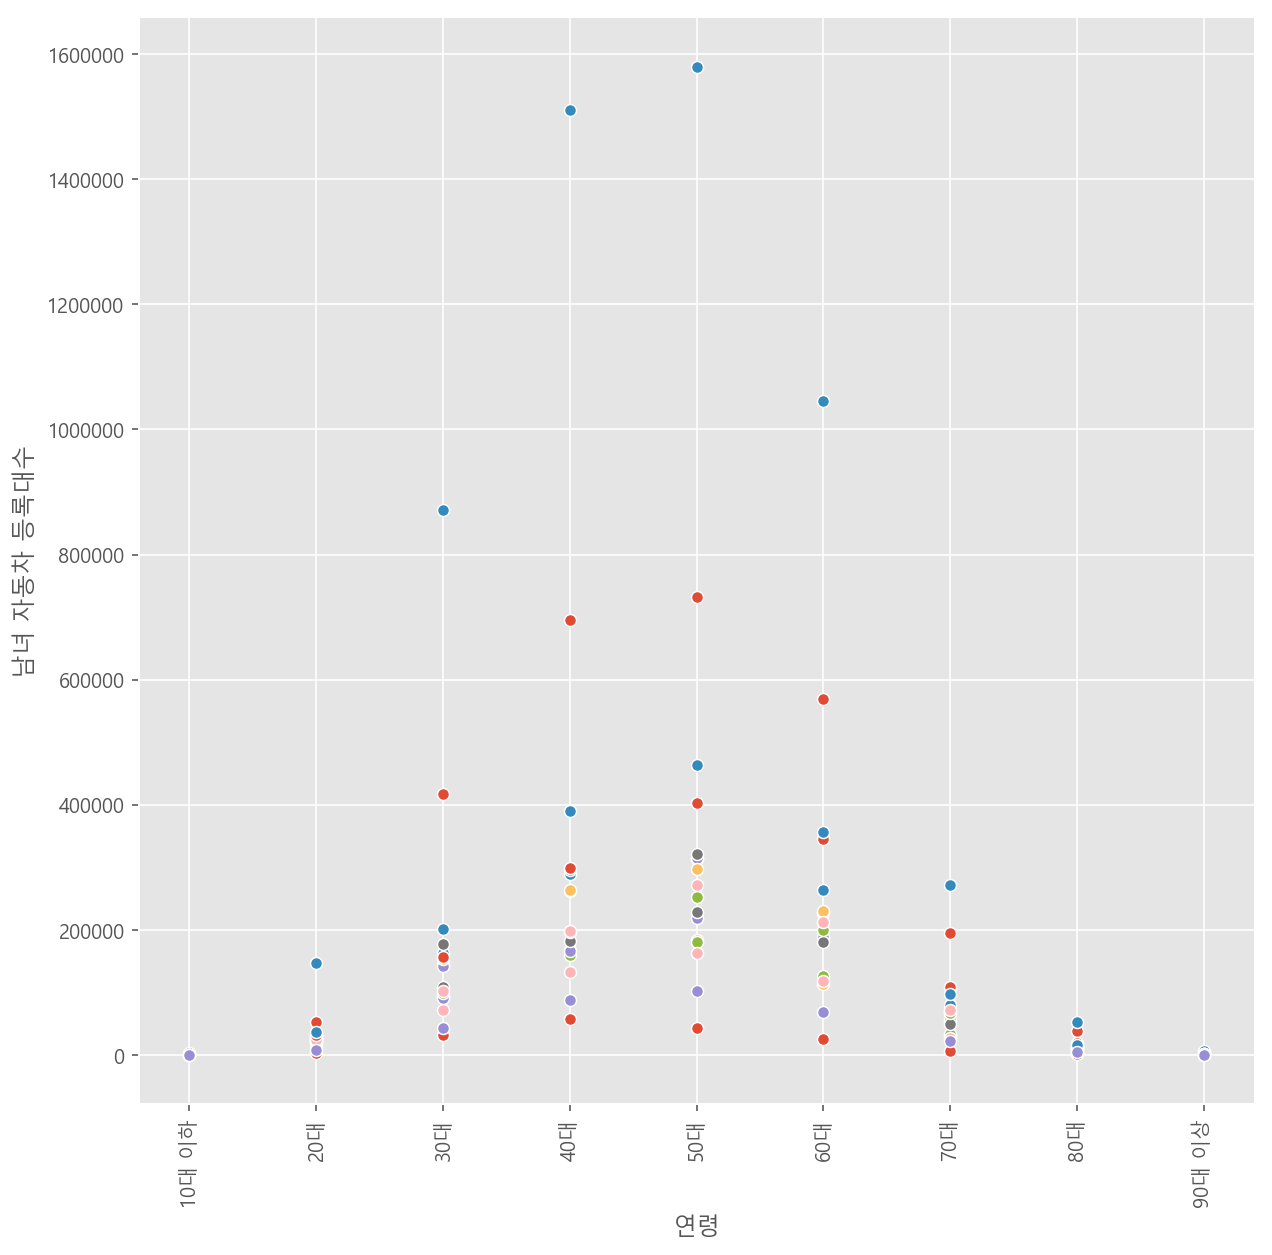

In [186]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation = 90 )

for i in grap_car.columns[3:-1] :
    sns.lineplot(x='연령', y=i, data=group, marker='o', linestyle = "none", alpha=1)
    
plt.ylabel("남녀 자동차 등록대수")

### 20 ~ 70대 임대주택 인구 비율 합산
- 20 ~ 70대의 자동차 등록비율이 높았기때문에

In [187]:
age.head(2)

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010


In [188]:
age['20~70대'] = age.iloc[:, 5:17].sum(axis=1)
age

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자),20~70대
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014,0.770990
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010,0.792032
2,대전광역시,0.028197,0.029092,0.040490,0.042793,0.060834,0.064247,0.068654,0.066848,0.074667,...,0.070261,0.051010,0.037143,0.032455,0.013751,0.006494,0.001740,0.000298,0.000066,0.804626
3,경기도,0.038030,0.039507,0.052546,0.053990,0.058484,0.059894,0.072331,0.068704,0.083208,...,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067,0.770983
4,전라북도,0.028089,0.029065,0.059685,0.060080,0.066262,0.070322,0.052027,0.046596,0.077005,...,0.068042,0.051025,0.035748,0.035049,0.012641,0.007223,0.001898,0.000158,0.000013,0.766098
5,강원도,0.028888,0.030682,0.051287,0.052712,0.060374,0.063157,0.059821,0.054321,0.076201,...,0.070014,0.047732,0.032760,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017,0.780250
6,광주광역시,0.031994,0.034566,0.049851,0.050254,0.065084,0.066875,0.066888,0.064416,0.080028,...,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013,0.785641
7,충청남도,0.031369,0.031711,0.059077,0.062422,0.067975,0.072622,0.065095,0.067303,0.078860,...,0.057692,0.042296,0.028682,0.024514,0.010900,0.005429,0.001549,0.000219,0.000123,0.772687
8,부산광역시,0.022003,0.022947,0.032681,0.035512,0.053796,0.057233,0.047049,0.048866,0.061952,...,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.002240,0.000268,0.000028,0.808142
9,제주특별자치도,0.034690,0.036695,0.060094,0.063080,0.069135,0.069667,0.050808,0.048026,0.080548,...,0.055717,0.047944,0.033054,0.026836,0.011332,0.006832,0.000982,0.000368,0.000082,0.759010


### Feature 추가(단지당 자동차 보유 가능 인구비율)
- 예측 feature 1 : 단지당 운전가능 인구수 구하기
    - 가설 : 자동차 보유 인구를 20대에서 70대로 가정하며, 해당 인구는 자신에게 등록된 차량이 모두 있다고 가정한다.
    - 공식 : 지역별 자동차 보유 가능 연령비율 / 지역별 총 세대수 * 단지별 세대수

In [189]:
all_df = pd.concat([train, test], ignore_index=True)
all_df.shape

(3904, 23)

In [190]:
def car_calc(data) :
    loc = data['지역']
    
    total_house = group.loc[loc, '총세대수'].sum()
    loc_house = data['총세대수']
    popul = age.loc[ age['지역'] == loc, '20~70대' ].values[0]
    
    result = (popul / total_house) * loc_house
    
    return result

In [191]:
grouped = all_df.groupby(['지역', '단지코드'])
group = grouped.mean()

all_df['단지당 자동차 보유 가능 인구비율'] = all_df.apply(car_calc, axis=1)

In [192]:
all_df

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,단지코드_Type,임대건물구분_lbl,지역_lbl,공급유형_lbl,자격유형_lbl,단지코드_lbl,qcut_총세대수,등록차량수,log_등록차량수,단지당 자동차 보유 가능 인구비율
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17.0,A,12672000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17.0,A,18433000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17.0,A,18433000.0,...,3.0,1,1,1,1,492,1,205.0,5.327876,0.009127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,C1267,675,아파트,경상남도,행복주택,36.77,126,38.0,L,0.0,...,1.0,1,1,9,12,86,2,NaN,NaN,0.011304
3900,C2189,382,아파트,전라북도,국민임대,29.19,96,45.0,H,6872000.0,...,1.0,1,4,1,8,381,0,NaN,NaN,0.016835
3901,C2189,382,아파트,전라북도,국민임대,29.19,20,45.0,H,6872000.0,...,1.0,1,4,1,8,381,0,NaN,NaN,0.016835
3902,C2189,382,아파트,전라북도,국민임대,39.45,202,45.0,H,13410000.0,...,1.0,1,4,1,8,381,0,NaN,NaN,0.016835


In [224]:
train = all_df.iloc[0:2896,:]
test = all_df.iloc[2896:,:]

test.drop(['등록차량수', 'log_등록차량수'], inplace=True, axis=1)

train.shape, test.shape

C:\Users\Su\Anaconda3\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((2896, 27), (1008, 25))

### Feature 추가(교통편의성 / 총세대수주차면수)

In [194]:
all_df['교통편의성'] = all_df['10분내지하철수'] + all_df['10분내버스정류장수']
all_df['총세대수주차면수'] =  all_df['단지내주차면수'] / all_df['총세대수']

# train['교통편의성'] = train['10분내지하철수'] + train['10분내버스정류장수']
# train['총세대수주차면수'] =  train['단지내주차면수'] / train['총세대수']

# test['교통편의성'] = test['10분내지하철수'] + test['10분내버스정류장수']
# test['총세대수주차면수'] =  test['단지내주차면수'] / test['총세대수']

### 전용면적 5배수 생성

In [195]:
# 전용면적 5배수
all_df['전용면적5배수'] = all_df['전용면적'] // 5 * 5

In [196]:
# 전용면적 상/하한 적용
# 상한100, 하한 15
idx = all_df[all_df['전용면적5배수'] > 100].index
all_df.loc[idx, '전용면적5배수'] = 100

idx = all_df[all_df['전용면적5배수'] < 15].index
all_df.loc[idx, '전용면적5배수'] = 15

### 임대료 결측치 0, mean, median처리 DataFrame 생성

In [197]:
all_df.isna().sum()

단지코드                     0
총세대수                     0
임대건물구분                   0
지역                       0
공급유형                     0
전용면적                     0
전용면적별세대수                 0
공가수                      0
자격유형                     0
임대보증금                    0
임대료                      0
10분내지하철수                 0
10분내버스정류장수               0
단지내주차면수                  0
단지코드_Type                0
임대건물구분_lbl               0
지역_lbl                   0
공급유형_lbl                 0
자격유형_lbl                 0
단지코드_lbl                 0
qcut_총세대수                0
등록차량수                 1008
log_등록차량수             1008
단지당 자동차 보유 가능 인구비율       0
교통편의성                    0
총세대수주차면수                 0
전용면적5배수                  0
dtype: int64

In [198]:
all_df.loc[ all_df['임대보증금'] == '-', '임대보증금'] = 0
all_df.loc[ all_df['임대료'] == '-', '임대료'] = 0 

In [199]:
# fee_mean1 = 
temp_df = all_df.loc[ ~all_df['임대보증금'].isna() ]
fee_mean1 = temp_df['임대보증금'].astype(int).mean()
fee_median1 = temp_df['임대보증금'].astype(int).median()

fee_mean2 = temp_df['임대료'].astype(int).mean()
fee_median2 = temp_df['임대료'].astype(int).median()

fee_mean1, fee_median1, fee_mean2, fee_median2

(21029851.229508195, 17499000.0, 151143.78073770492, 132770.0)

In [200]:
me_df1 = all_df.copy()
me_df2 = all_df.copy()
me_df3 = all_df.copy()

In [201]:
me_df1.loc[ me_df1['임대보증금'].isna(), '임대보증금'] = 0
me_df1.loc[ me_df1['임대료'].isna(), '임대료'] = 0

me_df2.loc[ me_df2['임대보증금'].isna(), '임대보증금'] = fee_mean1
me_df2.loc[ me_df2['임대료'].isna(), '임대료'] = fee_median1

me_df3.loc[ me_df3['임대보증금'].isna(), '임대보증금'] = fee_mean2
me_df3.loc[ me_df3['임대료'].isna(), '임대료'] = fee_median2

In [202]:
me_df1.isna().sum(), me_df2.isna().sum(), me_df3.isna().sum()

(단지코드                     0
 총세대수                     0
 임대건물구분                   0
 지역                       0
 공급유형                     0
 전용면적                     0
 전용면적별세대수                 0
 공가수                      0
 자격유형                     0
 임대보증금                    0
 임대료                      0
 10분내지하철수                 0
 10분내버스정류장수               0
 단지내주차면수                  0
 단지코드_Type                0
 임대건물구분_lbl               0
 지역_lbl                   0
 공급유형_lbl                 0
 자격유형_lbl                 0
 단지코드_lbl                 0
 qcut_총세대수                0
 등록차량수                 1008
 log_등록차량수             1008
 단지당 자동차 보유 가능 인구비율       0
 교통편의성                    0
 총세대수주차면수                 0
 전용면적5배수                  0
 dtype: int64, 단지코드                     0
 총세대수                     0
 임대건물구분                   0
 지역                       0
 공급유형                     0
 전용면적                     0
 전용면적별세대수                 0
 공가수                      0
 자격유형 

### Feature 별 상관관계 분석

### 정규화 및 정규분포 확인

### 임대료, 임대보증금 결측치 처리

In [203]:
scaler = RobustScaler()

scal_cols = ['총세대수', '전용면적', '전용면적별세대수', '공가수', 
             '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', 
             '단지내주차면수', '단지당 자동차 보유 가능 인구비율', '교통편의성',
             '총세대수주차면수']

scaler.fit(me_df1[scal_cols])
temp_me_df1_scal = pd.DataFrame(scaler.transform(me_df1[scal_cols]))

scaler.fit(me_df2[scal_cols])
temp_me_df2_scal = pd.DataFrame(scaler.transform(me_df2[scal_cols]))

scaler.fit(me_df3[scal_cols])
temp_me_df3_scal = pd.DataFrame(scaler.transform(me_df3[scal_cols]))

In [204]:
temp_me_df1_scal.columns = scal_cols
temp_me_df2_scal.columns = scal_cols
temp_me_df3_scal.columns = scal_cols

In [205]:
me_df1_scal = me_df1.copy()
me_df2_scal = me_df2.copy()
me_df3_scal = me_df3.copy()

In [206]:
me_df1_scal.loc[:, scal_cols] = temp_me_df1_scal[scal_cols]
me_df2_scal.loc[:, scal_cols] = temp_me_df2_scal[scal_cols]
me_df3_scal.loc[:, scal_cols] = temp_me_df3_scal[scal_cols]

In [207]:
me_df1_train = me_df1.iloc[0:2896,:]
me_df1_test = me_df1.iloc[2896:,:]

me_df1_test.drop(['등록차량수', 'log_등록차량수'], inplace=True, axis=1)

me_df2_train = me_df2.iloc[0:2896,:]
me_df2_test = me_df2.iloc[2896:,:]

me_df2_test.drop(['등록차량수', 'log_등록차량수'], inplace=True, axis=1)

me_df3_train = me_df3.iloc[0:2896,:]
me_df3_test = me_df3.iloc[2896:,:]

me_df3_test.drop(['등록차량수', 'log_등록차량수'], inplace=True, axis=1)


me_df1_scal_train = me_df1_scal.iloc[0:2896,:]
me_df1_scal_test = me_df1_scal.iloc[2896:,:]

me_df1_scal_test.drop(['등록차량수', 'log_등록차량수'], inplace=True, axis=1)

me_df2_scal_train = me_df2_scal.iloc[0:2896,:]
me_df2_scal_test = me_df2_scal.iloc[2896:,:]

me_df2_scal_test.drop(['등록차량수', 'log_등록차량수'], inplace=True, axis=1)

me_df3_scal_train = me_df3_scal.iloc[0:2896,:]
me_df3_scal_test = me_df3_scal.iloc[2896:,:]

me_df3_scal_test.drop(['등록차량수', 'log_등록차량수'], inplace=True, axis=1)


C:\Users\Su\Anaconda3\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [208]:
me_df3_scal.shape

(3904, 27)

In [209]:
scaler = RobustScaler()

scal_cols = ['총세대수', '전용면적', '전용면적별세대수', '공가수', 
             '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', 
             '단지내주차면수', '단지당 자동차 보유 가능 인구비율', '교통편의성',
             '총세대수주차면수']

scal_all_df = all_df[scal_cols].copy()
scaler.fit(scal_all_df[scal_cols])

scal_all_df = pd.DataFrame(scaler.transform(scal_all_df[scal_cols]))

In [210]:
# _ = scal_all_df.hist(figsize=(20, 20), bins=100)
# plt.tight_layout()

In [211]:
# _ = train[scal_cols].hist(figsize=(20, 20), bins=50)
# plt.tight_layout()

In [212]:
train.corr()['log_등록차량수'].sort_values()

임대건물구분_lbl   -0.596565
공급유형_lbl     -0.291515
자격유형_lbl     -0.239157
10분내지하철수     -0.153996
단지코드_lbl     -0.065896
10분내버스정류장수    0.080114
단지코드_Type     0.093261
지역_lbl        0.108532
전용면적          0.111644
공가수           0.200793
총세대수          0.228964
전용면적별세대수      0.274772
qcut_총세대수     0.303550
임대보증금         0.458732
임대료           0.557954
단지내주차면수       0.805096
등록차량수         0.881679
log_등록차량수     1.000000
Name: log_등록차량수, dtype: float64

In [213]:
train_ml.corr()['등록차량수'].sort_values()

임대건물구분_lbl   -0.449130
자격유형_lbl     -0.154482
공급유형_lbl     -0.137277
10분내지하철수     -0.127452
단지코드_lbl     -0.062077
지역_lbl        0.060674
10분내버스정류장수    0.104189
단지코드_Type     0.109893
전용면적          0.112717
공가수           0.118910
전용면적별세대수      0.250513
총세대수          0.333440
qcut_총세대수     0.401309
임대료           0.435258
임대보증금         0.439936
단지내주차면수       0.861338
log_등록차량수     0.881679
등록차량수         1.000000
Name: 등록차량수, dtype: float64

In [214]:
# train[]

### Feature 중요도 확인

In [215]:
def plot_feature_important_common(model, col_names):
    imp = model.feature_importances_                   # feature의 중요도
    n_features = len(col_names)
    feature_names = col_names
    plt.barh(range(n_features) , imp, align='center')  # 그래프(가로 막대 그래프)
    plt.yticks(np.arange(n_features), feature_names)   # y축 값 지정
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features)

### 모델데이터 생성

In [216]:
# imp = model.feature_importances_                   # feature의 중요도
# n_features = len(sel)
# feature_names = sel
# plt.figure(figsize=(12,6))
# plt.barh(range(n_features) , imp, align='center')  # 그래프(가로 막대 그래프)
# plt.yticks(np.arange(n_features), feature_names)   # y축 값 지정
# plt.xlabel("feature importance")
# plt.ylabel("feature")
# plt.ylim(-1, n_features)

In [217]:
def model_catboost_score(sel, train, test) :
    
    X = train[sel]
    y = train['log_등록차량수']
    test_X = test[sel]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

    model.fit(X_train, y_train)
    
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    
    now_time = time.time()

    score = cross_val_score(model, X_train, y_train,
                            cv=5, scoring="neg_mean_absolute_error") # neg_mean_squared_error
    m_score = np.abs(score.mean())

    pro_time = time.time() - now_time
    print('Time :', pro_time)  # 걸린 시간
        
    print('Train :', train_score)
    print('Test :', test_score)
    print("CatBoostRegressor Score : {}".format(m_score))  # 점수
    
    plot_feature_important_common(model, sel)


1. '총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '임대건물구분_lbl', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수'
  - 0
    - Train : 0.969667933141996
    - Test : 0.9556545860859712
    - MAE : 0.10894951897736851
  - ML
    - Train : 0.9650052334394816
    - Test : 0.952464735797971
    - MAE : 0.1155802513018647
2. '총세대수', '전용면적', '전용면적별세대수', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '임대건물구분_lbl', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수'
  - 임대료, 임대보증금이 정말 영향이 있을까 싶어서 제거해보았음
    - Train : 0.9659899308941171
    - Test : 0.9604956187319048
    - CatBoostRegressor Score : 0.1043724049246422
3. '총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '임대건물구분_lbl', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수'
  - 0
    - Train : 0.969667933141996
    - Test : 0.9556545860859712
    - CatBoostRegressor Score : 0.10894951897736851
  - ML
    - Train : 0.9621797461108202
    - Test : 0.9544715446593343
    - CatBoostRegressor Score : 0.11546486789673563
    2. '총세대수', '전용면적', '전용면적별세대수', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
4. '총세대수', '전용면적', '전용면적별세대수', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '임대건물구분_lbl', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수', '교통편의성', '총세대수주차면수'
  - Train : 0.9691612160338604
  - Test : 0.9550798483985361
  - CatBoostRegressor Score : 0.10306740764454218
5. '총세대수', '전용면적', '전용면적별세대수', '공가수', '10분내지하철수', '10분내버스정류장수', '단지내주차면수',
'단지코드_Type', '지역_lbl', '공급유형_lbl', '자격유형_lbl', '단지코드_lbl',
'qcut_총세대수', '교통편의성', '총세대수주차면수'
  - Train : 0.9642501969559543
  - Test : 0.9549268671295694
  - CatBoostRegressor Score : 0.10058613391437125
6. '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '임대건물구분_lbl', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
  - Train : 0.9636703246834547
  - Test : 0.957921832563748
  - CatBoostRegressor Score : 0.10093651220804309
7. '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '임대건물구분_lbl', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수','임대료','임대보증금'
  - Train : 0.9689002063896195
  - Test : 0.9572092497188488
  - CatBoostRegressor Score : 0.10434721441993702
8. '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
  - Train : 0.9660290240496178
  - Test : 0.9582228452461531
  - CatBoostRegressor Score : 0.09814497306425582
9. '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수', '단지당 자동차 보유 가능 인구비율'
  - Train : 0.9697139261976446
  - Test : 0.9565215351314059
  - CatBoostRegressor Score : 0.09731382008727066
10. 임대료, 임대보증금 0
  - '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
    '10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
    '교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
      - Train : 0.9660290240496178
      - Test : 0.9582228452461531
      - CatBoostRegressor Score : 0.09814497306425582
11. 임대료, 임대보증금 0(정규화)
  - '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
       '10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
       '교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
      - Train : 0.9660290240496178
      - Test : 0.9582228452461531
      - CatBoostRegressor Score : 0.09813813832407789
12. 임대료, 임대보증금 평균
  - '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
       '10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
       '교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
      - Train : 0.965859204108208
      - Test : 0.958402011913117
      - CatBoostRegressor Score : 0.09866541990181212
13. 임대료, 임대보증금 평균(정규화)
  - '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
       '10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
       '교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
      - Train : 0.965859204108208
      - Test : 0.958402011913117
      - CatBoostRegressor Score : 0.09866521857112517
14. 임대료, 임대보증금 중위값
  - '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
       '10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
       '교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
      - Train : 0.9737498233465798
      - Test : 0.9616596684259887
      - CatBoostRegressor Score : 0.10031259946281819
15. 임대료, 임대보증금 중위값(정규화)
  - '총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
       '10분내버스정류장수', '10분내지하철수', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
       '교통편의성','총세대수주차면수','임대료','임대보증금', '단지당 자동차 보유 가능 인구비율'
      - Train : 0.9737498233465798
      - Test : 0.9616596684259887
      - CatBoostRegressor Score : 0.1003152646715832
16. '총세대수', '전용면적5배수', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
'10분내버스정류장수', '10분내지하철수', '임대건물구분_lbl', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
'교통편의성','총세대수주차면수','임대료','임대보증금'
      - Train : 0.9639079693512697
      - Test : 0.9501177943824
      - CatBoostRegressor Score : 0.10502989211565845


In [218]:
# 8 / 9
0.09814497306425582 <  0.09731382008727066

False

In [219]:
score_df = pd.DataFrame({'me_df1' : [0.09814497306425582],
                         'me_df2' : [0.09866541990181212],
                         'me_df3' : [0.10031259946281819],
                         'me_df1_scal' : [0.09813813832407789],
                         'me_df2_scal' :[0.09866521857112517],
                         'me_df3_scal' : [0.1003152646715832]})
score_df

,me_df1,me_df2,me_df3,me_df1_scal,me_df2_scal,me_df3_scal
0,0.098145,0.098665,0.100313,0.098138,0.098665,0.100315


In [220]:
score_df.T.sort_values(0)

,0
me_df1_scal,0.098138
me_df1,0.098145
me_df2_scal,0.098665
me_df2,0.098665
me_df3,0.100313
me_df3_scal,0.100315


In [225]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   단지코드                2896 non-null   object 
 1   총세대수                2896 non-null   int64  
 2   임대건물구분              2896 non-null   object 
 3   지역                  2896 non-null   object 
 4   공급유형                2896 non-null   object 
 5   전용면적                2896 non-null   float64
 6   전용면적별세대수            2896 non-null   int64  
 7   공가수                 2896 non-null   float64
 8   자격유형                2896 non-null   object 
 9   임대보증금               2896 non-null   float64
 10  임대료                 2896 non-null   float64
 11  10분내지하철수            2896 non-null   float64
 12  10분내버스정류장수          2896 non-null   float64
 13  단지내주차면수             2896 non-null   float64
 14  단지코드_Type           2896 non-null   float64
 15  임대건물구분_lbl          2896 non-null   int64  
 16  지역_lbl

In [246]:
train.corr()['log_등록차량수'].sort_values()

임대건물구분_lbl           -0.596565
공급유형_lbl             -0.291515
자격유형_lbl             -0.239157
10분내지하철수             -0.153996
단지코드_lbl             -0.065896
교통편의성                 0.053589
10분내버스정류장수            0.080114
단지코드_Type             0.093261
지역_lbl                0.108532
전용면적                  0.111644
단지당 자동차 보유 가능 인구비율    0.174055
공가수                   0.200793
총세대수                  0.228964
전용면적별세대수              0.274772
qcut_총세대수             0.303550
전용면적5배수               0.352504
임대보증금                 0.458732
임대료                   0.557954
총세대수주차면수              0.735821
단지내주차면수               0.805096
등록차량수                 0.881679
log_등록차량수             1.000000
Name: log_등록차량수, dtype: float64

In [241]:
sel = ['총세대수', '전용면적', '공가수', '단지내주차면수','qcut_총세대수', '자격유형_lbl', '전용면적별세대수',
       '10분내버스정류장수', '10분내지하철수', '임대건물구분_lbl', '공급유형_lbl', '지역_lbl', '단지코드_lbl','단지코드_Type',
       '교통편의성','총세대수주차면수','임대료','임대보증금']

    # me_df1_train
    # me_df1_test
    # me_df2_train
    # me_df2_test
    # me_df3_train
    # me_df3_test

    # me_df1_scal_train
    # me_df1_scal_test
    # me_df2_scal_train
    # me_df2_scal_test
    # me_df3_scal_train
    # me_df3_scal_test

X = train[sel]
y = train['log_등록차량수']
test_X = test[sel]

# X = me_df1_train[sel]
# y = me_df1_train['등록차량수']
# test_X = me_df1_test[sel]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

0:	learn: 0.6866655	total: 5.53ms	remaining: 2.76s
1:	learn: 0.6614938	total: 15.5ms	remaining: 3.87s
2:	learn: 0.6344400	total: 22ms	remaining: 3.64s
3:	learn: 0.6091668	total: 26.2ms	remaining: 3.25s
4:	learn: 0.5857253	total: 29.9ms	remaining: 2.96s
5:	learn: 0.5658801	total: 37.4ms	remaining: 3.08s
6:	learn: 0.5452965	total: 44.6ms	remaining: 3.14s
7:	learn: 0.5260196	total: 49ms	remaining: 3.01s
8:	learn: 0.5074027	total: 54.1ms	remaining: 2.95s
9:	learn: 0.4891090	total: 58.8ms	remaining: 2.88s
10:	learn: 0.4728589	total: 62.8ms	remaining: 2.79s
11:	learn: 0.4574765	total: 68.5ms	remaining: 2.79s
12:	learn: 0.4437467	total: 74.3ms	remaining: 2.78s
13:	learn: 0.4312595	total: 78.8ms	remaining: 2.74s
14:	learn: 0.4198574	total: 84ms	remaining: 2.71s
15:	learn: 0.4089071	total: 90.5ms	remaining: 2.74s
16:	learn: 0.3961280	total: 94.6ms	remaining: 2.69s
17:	learn: 0.3852310	total: 98.9ms	remaining: 2.65s
18:	learn: 0.3747194	total: 104ms	remaining: 2.62s
19:	learn: 0.3659014	total: 1

179:	learn: 0.1217695	total: 1.02s	remaining: 1.82s
180:	learn: 0.1215818	total: 1.03s	remaining: 1.81s
181:	learn: 0.1214516	total: 1.03s	remaining: 1.81s
182:	learn: 0.1213292	total: 1.04s	remaining: 1.8s
183:	learn: 0.1207368	total: 1.05s	remaining: 1.8s
184:	learn: 0.1205932	total: 1.05s	remaining: 1.79s
185:	learn: 0.1203581	total: 1.06s	remaining: 1.79s
186:	learn: 0.1201961	total: 1.06s	remaining: 1.78s
187:	learn: 0.1199890	total: 1.07s	remaining: 1.77s
188:	learn: 0.1197756	total: 1.07s	remaining: 1.76s
189:	learn: 0.1193243	total: 1.08s	remaining: 1.76s
190:	learn: 0.1190685	total: 1.08s	remaining: 1.75s
191:	learn: 0.1189258	total: 1.09s	remaining: 1.75s
192:	learn: 0.1187829	total: 1.09s	remaining: 1.74s
193:	learn: 0.1185486	total: 1.1s	remaining: 1.73s
194:	learn: 0.1183278	total: 1.1s	remaining: 1.72s
195:	learn: 0.1181206	total: 1.11s	remaining: 1.72s
196:	learn: 0.1179163	total: 1.11s	remaining: 1.71s
197:	learn: 0.1176809	total: 1.13s	remaining: 1.72s
198:	learn: 0.11

349:	learn: 0.0943274	total: 2.04s	remaining: 876ms
350:	learn: 0.0941559	total: 2.05s	remaining: 871ms
351:	learn: 0.0941191	total: 2.06s	remaining: 865ms
352:	learn: 0.0939164	total: 2.06s	remaining: 859ms
353:	learn: 0.0937817	total: 2.07s	remaining: 854ms
354:	learn: 0.0936358	total: 2.07s	remaining: 847ms
355:	learn: 0.0935972	total: 2.08s	remaining: 842ms
356:	learn: 0.0935500	total: 2.09s	remaining: 836ms
357:	learn: 0.0934763	total: 2.09s	remaining: 830ms
358:	learn: 0.0933984	total: 2.1s	remaining: 827ms
359:	learn: 0.0933027	total: 2.11s	remaining: 821ms
360:	learn: 0.0932282	total: 2.12s	remaining: 817ms
361:	learn: 0.0929969	total: 2.13s	remaining: 812ms
362:	learn: 0.0929017	total: 2.14s	remaining: 807ms
363:	learn: 0.0927403	total: 2.15s	remaining: 802ms
364:	learn: 0.0926477	total: 2.15s	remaining: 795ms
365:	learn: 0.0926224	total: 2.15s	remaining: 788ms
366:	learn: 0.0925288	total: 2.16s	remaining: 781ms
367:	learn: 0.0924602	total: 2.17s	remaining: 778ms
368:	learn: 0

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for mor

0:	learn: 0.6914878	total: 5.32ms	remaining: 2.65s
1:	learn: 0.6642985	total: 10.8ms	remaining: 2.68s
2:	learn: 0.6379481	total: 15.7ms	remaining: 2.61s
3:	learn: 0.6122326	total: 22.7ms	remaining: 2.82s
4:	learn: 0.5898501	total: 30.7ms	remaining: 3.04s
5:	learn: 0.5680341	total: 37.6ms	remaining: 3.1s
6:	learn: 0.5493230	total: 49.1ms	remaining: 3.46s
7:	learn: 0.5311740	total: 54.9ms	remaining: 3.38s
8:	learn: 0.5151274	total: 59.8ms	remaining: 3.26s
9:	learn: 0.4979397	total: 65.3ms	remaining: 3.2s
10:	learn: 0.4801710	total: 70.6ms	remaining: 3.14s
11:	learn: 0.4626814	total: 77.2ms	remaining: 3.14s
12:	learn: 0.4488605	total: 83.3ms	remaining: 3.12s
13:	learn: 0.4355392	total: 91.6ms	remaining: 3.18s
14:	learn: 0.4215032	total: 96.8ms	remaining: 3.13s
15:	learn: 0.4091115	total: 101ms	remaining: 3.05s
16:	learn: 0.3977656	total: 106ms	remaining: 3.02s
17:	learn: 0.3866430	total: 113ms	remaining: 3.02s
18:	learn: 0.3761950	total: 120ms	remaining: 3.03s
19:	learn: 0.3656390	total: 

166:	learn: 0.1288483	total: 1.02s	remaining: 2.04s
167:	learn: 0.1282244	total: 1.03s	remaining: 2.04s
168:	learn: 0.1280718	total: 1.04s	remaining: 2.04s
169:	learn: 0.1275567	total: 1.05s	remaining: 2.04s
170:	learn: 0.1272519	total: 1.06s	remaining: 2.03s
171:	learn: 0.1269452	total: 1.06s	remaining: 2.03s
172:	learn: 0.1260917	total: 1.07s	remaining: 2.02s
173:	learn: 0.1259302	total: 1.07s	remaining: 2.01s
174:	learn: 0.1251865	total: 1.08s	remaining: 2.01s
175:	learn: 0.1248939	total: 1.09s	remaining: 2.01s
176:	learn: 0.1246798	total: 1.1s	remaining: 2.01s
177:	learn: 0.1244515	total: 1.1s	remaining: 2s
178:	learn: 0.1239723	total: 1.11s	remaining: 2s
179:	learn: 0.1236254	total: 1.12s	remaining: 1.99s
180:	learn: 0.1233915	total: 1.13s	remaining: 2s
181:	learn: 0.1231409	total: 1.14s	remaining: 1.99s
182:	learn: 0.1229916	total: 1.15s	remaining: 1.99s
183:	learn: 0.1227475	total: 1.16s	remaining: 1.99s
184:	learn: 0.1225226	total: 1.16s	remaining: 1.98s
185:	learn: 0.1222729	t

325:	learn: 0.0952604	total: 2.03s	remaining: 1.08s
326:	learn: 0.0951770	total: 2.03s	remaining: 1.07s
327:	learn: 0.0950886	total: 2.04s	remaining: 1.07s
328:	learn: 0.0950006	total: 2.05s	remaining: 1.06s
329:	learn: 0.0948964	total: 2.05s	remaining: 1.06s
330:	learn: 0.0947448	total: 2.06s	remaining: 1.05s
331:	learn: 0.0945444	total: 2.07s	remaining: 1.05s
332:	learn: 0.0944267	total: 2.07s	remaining: 1.04s
333:	learn: 0.0942510	total: 2.08s	remaining: 1.03s
334:	learn: 0.0940917	total: 2.08s	remaining: 1.02s
335:	learn: 0.0940196	total: 2.09s	remaining: 1.02s
336:	learn: 0.0937296	total: 2.09s	remaining: 1.01s
337:	learn: 0.0933892	total: 2.1s	remaining: 1s
338:	learn: 0.0933102	total: 2.1s	remaining: 999ms
339:	learn: 0.0931562	total: 2.11s	remaining: 992ms
340:	learn: 0.0929665	total: 2.11s	remaining: 985ms
341:	learn: 0.0927844	total: 2.12s	remaining: 978ms
342:	learn: 0.0926966	total: 2.12s	remaining: 972ms
343:	learn: 0.0926207	total: 2.14s	remaining: 969ms
344:	learn: 0.092

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


0:	learn: 0.6859380	total: 4.13ms	remaining: 2.06s
1:	learn: 0.6603598	total: 9.99ms	remaining: 2.49s
2:	learn: 0.6333854	total: 14.7ms	remaining: 2.44s
3:	learn: 0.6086746	total: 20.4ms	remaining: 2.53s
4:	learn: 0.5867741	total: 28.6ms	remaining: 2.83s
5:	learn: 0.5665496	total: 33.4ms	remaining: 2.75s
6:	learn: 0.5477457	total: 38.9ms	remaining: 2.74s
7:	learn: 0.5299412	total: 43ms	remaining: 2.65s
8:	learn: 0.5136171	total: 47.5ms	remaining: 2.59s
9:	learn: 0.4941673	total: 58.6ms	remaining: 2.87s
10:	learn: 0.4774736	total: 62.9ms	remaining: 2.8s
11:	learn: 0.4627654	total: 76.1ms	remaining: 3.09s
12:	learn: 0.4494858	total: 79.7ms	remaining: 2.99s
13:	learn: 0.4359793	total: 83.8ms	remaining: 2.91s
14:	learn: 0.4223279	total: 88.3ms	remaining: 2.85s
15:	learn: 0.4113225	total: 93ms	remaining: 2.81s
16:	learn: 0.3999477	total: 97ms	remaining: 2.76s
17:	learn: 0.3874252	total: 103ms	remaining: 2.75s
18:	learn: 0.3771999	total: 115ms	remaining: 2.91s
19:	learn: 0.3671159	total: 120

166:	learn: 0.1257605	total: 1.01s	remaining: 2.02s
167:	learn: 0.1255185	total: 1.02s	remaining: 2.02s
168:	learn: 0.1251811	total: 1.02s	remaining: 2.01s
169:	learn: 0.1248753	total: 1.03s	remaining: 2s
170:	learn: 0.1245662	total: 1.04s	remaining: 2s
171:	learn: 0.1243998	total: 1.04s	remaining: 1.99s
172:	learn: 0.1236249	total: 1.05s	remaining: 1.98s
173:	learn: 0.1232327	total: 1.05s	remaining: 1.97s
174:	learn: 0.1229447	total: 1.06s	remaining: 1.97s
175:	learn: 0.1223592	total: 1.06s	remaining: 1.96s
176:	learn: 0.1218840	total: 1.07s	remaining: 1.95s
177:	learn: 0.1214513	total: 1.07s	remaining: 1.94s
178:	learn: 0.1208737	total: 1.08s	remaining: 1.93s
179:	learn: 0.1205646	total: 1.08s	remaining: 1.92s
180:	learn: 0.1203627	total: 1.09s	remaining: 1.91s
181:	learn: 0.1202204	total: 1.09s	remaining: 1.91s
182:	learn: 0.1201060	total: 1.1s	remaining: 1.9s
183:	learn: 0.1196959	total: 1.1s	remaining: 1.89s
184:	learn: 0.1194074	total: 1.11s	remaining: 1.89s
185:	learn: 0.1192353

348:	learn: 0.0884409	total: 2.01s	remaining: 871ms
349:	learn: 0.0883657	total: 2.02s	remaining: 865ms
350:	learn: 0.0881912	total: 2.02s	remaining: 859ms
351:	learn: 0.0880962	total: 2.03s	remaining: 853ms
352:	learn: 0.0879765	total: 2.03s	remaining: 847ms
353:	learn: 0.0879009	total: 2.04s	remaining: 841ms
354:	learn: 0.0877540	total: 2.04s	remaining: 836ms
355:	learn: 0.0877086	total: 2.05s	remaining: 831ms
356:	learn: 0.0876746	total: 2.07s	remaining: 828ms
357:	learn: 0.0875927	total: 2.07s	remaining: 821ms
358:	learn: 0.0874666	total: 2.07s	remaining: 815ms
359:	learn: 0.0874218	total: 2.08s	remaining: 809ms
360:	learn: 0.0873953	total: 2.09s	remaining: 804ms
361:	learn: 0.0872841	total: 2.09s	remaining: 798ms
362:	learn: 0.0872397	total: 2.1s	remaining: 792ms
363:	learn: 0.0871248	total: 2.1s	remaining: 786ms
364:	learn: 0.0870529	total: 2.11s	remaining: 779ms
365:	learn: 0.0870184	total: 2.11s	remaining: 773ms
366:	learn: 0.0868629	total: 2.12s	remaining: 769ms
367:	learn: 0.

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


0:	learn: 0.6872673	total: 5.96ms	remaining: 2.98s
1:	learn: 0.6602471	total: 10.4ms	remaining: 2.58s
2:	learn: 0.6332619	total: 14.5ms	remaining: 2.4s
3:	learn: 0.6091280	total: 21.9ms	remaining: 2.71s
4:	learn: 0.5867324	total: 27ms	remaining: 2.67s
5:	learn: 0.5656126	total: 31.7ms	remaining: 2.61s
6:	learn: 0.5469872	total: 35.9ms	remaining: 2.53s
7:	learn: 0.5277083	total: 42.1ms	remaining: 2.59s
8:	learn: 0.5095676	total: 48.7ms	remaining: 2.66s
9:	learn: 0.4926398	total: 53.3ms	remaining: 2.61s
10:	learn: 0.4762791	total: 57.4ms	remaining: 2.55s
11:	learn: 0.4588623	total: 62.1ms	remaining: 2.52s
12:	learn: 0.4435818	total: 68.2ms	remaining: 2.56s
13:	learn: 0.4310470	total: 73.9ms	remaining: 2.56s
14:	learn: 0.4190501	total: 94.4ms	remaining: 3.05s
15:	learn: 0.4085893	total: 111ms	remaining: 3.35s
16:	learn: 0.3973631	total: 115ms	remaining: 3.27s
17:	learn: 0.3852645	total: 120ms	remaining: 3.21s
18:	learn: 0.3735719	total: 130ms	remaining: 3.3s
19:	learn: 0.3637930	total: 13

180:	learn: 0.1202245	total: 1.56s	remaining: 2.74s
181:	learn: 0.1200304	total: 1.56s	remaining: 2.73s
182:	learn: 0.1196959	total: 1.57s	remaining: 2.73s
183:	learn: 0.1194614	total: 1.58s	remaining: 2.71s
184:	learn: 0.1192340	total: 1.59s	remaining: 2.7s
185:	learn: 0.1190675	total: 1.6s	remaining: 2.69s
186:	learn: 0.1188881	total: 1.6s	remaining: 2.68s
187:	learn: 0.1187528	total: 1.61s	remaining: 2.68s
188:	learn: 0.1183610	total: 1.62s	remaining: 2.67s
189:	learn: 0.1181311	total: 1.63s	remaining: 2.65s
190:	learn: 0.1177116	total: 1.64s	remaining: 2.65s
191:	learn: 0.1173743	total: 1.65s	remaining: 2.64s
192:	learn: 0.1171193	total: 1.65s	remaining: 2.63s
193:	learn: 0.1170427	total: 1.67s	remaining: 2.63s
194:	learn: 0.1167071	total: 1.69s	remaining: 2.64s
195:	learn: 0.1162171	total: 1.7s	remaining: 2.64s
196:	learn: 0.1159564	total: 1.71s	remaining: 2.63s
197:	learn: 0.1156188	total: 1.72s	remaining: 2.63s
198:	learn: 0.1154253	total: 1.74s	remaining: 2.63s
199:	learn: 0.11

347:	learn: 0.0898951	total: 3.43s	remaining: 1.5s
348:	learn: 0.0898054	total: 3.44s	remaining: 1.49s
349:	learn: 0.0897343	total: 3.45s	remaining: 1.48s
350:	learn: 0.0896495	total: 3.46s	remaining: 1.47s
351:	learn: 0.0895598	total: 3.46s	remaining: 1.46s
352:	learn: 0.0893027	total: 3.47s	remaining: 1.45s
353:	learn: 0.0891889	total: 3.48s	remaining: 1.44s
354:	learn: 0.0888949	total: 3.5s	remaining: 1.43s
355:	learn: 0.0888148	total: 3.51s	remaining: 1.42s
356:	learn: 0.0887025	total: 3.52s	remaining: 1.41s
357:	learn: 0.0885766	total: 3.53s	remaining: 1.4s
358:	learn: 0.0884028	total: 3.54s	remaining: 1.39s
359:	learn: 0.0882955	total: 3.55s	remaining: 1.38s
360:	learn: 0.0882272	total: 3.56s	remaining: 1.37s
361:	learn: 0.0881019	total: 3.56s	remaining: 1.36s
362:	learn: 0.0880600	total: 3.58s	remaining: 1.35s
363:	learn: 0.0879313	total: 3.59s	remaining: 1.34s
364:	learn: 0.0878393	total: 3.6s	remaining: 1.33s
365:	learn: 0.0878075	total: 3.61s	remaining: 1.32s
366:	learn: 0.08

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


0:	learn: 0.6836375	total: 7.16ms	remaining: 3.57s
1:	learn: 0.6582495	total: 15ms	remaining: 3.74s
2:	learn: 0.6325525	total: 21.7ms	remaining: 3.59s
3:	learn: 0.6078257	total: 30.5ms	remaining: 3.78s
4:	learn: 0.5846015	total: 41.1ms	remaining: 4.07s
5:	learn: 0.5648256	total: 59.8ms	remaining: 4.93s
6:	learn: 0.5451467	total: 70.4ms	remaining: 4.96s
7:	learn: 0.5251918	total: 77.6ms	remaining: 4.77s
8:	learn: 0.5093045	total: 83.7ms	remaining: 4.57s
9:	learn: 0.4912296	total: 94.7ms	remaining: 4.64s
10:	learn: 0.4745647	total: 115ms	remaining: 5.09s
11:	learn: 0.4604055	total: 121ms	remaining: 4.93s
12:	learn: 0.4459066	total: 140ms	remaining: 5.23s
13:	learn: 0.4322785	total: 149ms	remaining: 5.16s
14:	learn: 0.4191095	total: 160ms	remaining: 5.18s
15:	learn: 0.4081918	total: 180ms	remaining: 5.43s
16:	learn: 0.3960497	total: 192ms	remaining: 5.44s
17:	learn: 0.3843333	total: 199ms	remaining: 5.32s
18:	learn: 0.3730048	total: 209ms	remaining: 5.28s
19:	learn: 0.3630626	total: 222ms

167:	learn: 0.1252497	total: 1.36s	remaining: 2.7s
168:	learn: 0.1247788	total: 1.37s	remaining: 2.69s
169:	learn: 0.1245256	total: 1.38s	remaining: 2.68s
170:	learn: 0.1239161	total: 1.38s	remaining: 2.66s
171:	learn: 0.1234288	total: 1.39s	remaining: 2.65s
172:	learn: 0.1231060	total: 1.4s	remaining: 2.65s
173:	learn: 0.1225442	total: 1.41s	remaining: 2.64s
174:	learn: 0.1223068	total: 1.41s	remaining: 2.63s
175:	learn: 0.1216849	total: 1.42s	remaining: 2.62s
176:	learn: 0.1214994	total: 1.43s	remaining: 2.61s
177:	learn: 0.1213665	total: 1.44s	remaining: 2.6s
178:	learn: 0.1208913	total: 1.45s	remaining: 2.6s
179:	learn: 0.1207160	total: 1.46s	remaining: 2.59s
180:	learn: 0.1203064	total: 1.47s	remaining: 2.58s
181:	learn: 0.1202195	total: 1.47s	remaining: 2.57s
182:	learn: 0.1199698	total: 1.48s	remaining: 2.57s
183:	learn: 0.1193843	total: 1.49s	remaining: 2.56s
184:	learn: 0.1189997	total: 1.49s	remaining: 2.54s
185:	learn: 0.1187255	total: 1.5s	remaining: 2.54s
186:	learn: 0.118

342:	learn: 0.0920310	total: 2.73s	remaining: 1.25s
343:	learn: 0.0919398	total: 2.73s	remaining: 1.24s
344:	learn: 0.0919147	total: 2.74s	remaining: 1.23s
345:	learn: 0.0918285	total: 2.75s	remaining: 1.22s
346:	learn: 0.0916683	total: 2.77s	remaining: 1.22s
347:	learn: 0.0915711	total: 2.79s	remaining: 1.22s
348:	learn: 0.0914891	total: 2.81s	remaining: 1.22s
349:	learn: 0.0913945	total: 2.82s	remaining: 1.21s
350:	learn: 0.0912760	total: 2.83s	remaining: 1.2s
351:	learn: 0.0912565	total: 2.84s	remaining: 1.2s
352:	learn: 0.0912416	total: 2.85s	remaining: 1.19s
353:	learn: 0.0912074	total: 2.86s	remaining: 1.18s
354:	learn: 0.0911212	total: 2.87s	remaining: 1.17s
355:	learn: 0.0909978	total: 2.88s	remaining: 1.17s
356:	learn: 0.0909675	total: 2.91s	remaining: 1.17s
357:	learn: 0.0909061	total: 2.93s	remaining: 1.16s
358:	learn: 0.0907955	total: 2.94s	remaining: 1.15s
359:	learn: 0.0907562	total: 2.96s	remaining: 1.15s
360:	learn: 0.0906846	total: 2.98s	remaining: 1.15s
361:	learn: 0.

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


2:	learn: 0.6403004	total: 29.7ms	remaining: 4.92s
3:	learn: 0.6156974	total: 40.6ms	remaining: 5.04s
4:	learn: 0.5923928	total: 51.1ms	remaining: 5.06s
5:	learn: 0.5696585	total: 59.5ms	remaining: 4.9s
6:	learn: 0.5492534	total: 73.4ms	remaining: 5.17s
7:	learn: 0.5315314	total: 85.9ms	remaining: 5.28s
8:	learn: 0.5123360	total: 98.3ms	remaining: 5.36s
9:	learn: 0.4955728	total: 107ms	remaining: 5.23s
10:	learn: 0.4782432	total: 122ms	remaining: 5.43s
11:	learn: 0.4610230	total: 131ms	remaining: 5.32s
12:	learn: 0.4461117	total: 156ms	remaining: 5.85s
13:	learn: 0.4327124	total: 172ms	remaining: 5.97s
14:	learn: 0.4188156	total: 179ms	remaining: 5.8s
15:	learn: 0.4070672	total: 198ms	remaining: 6s
16:	learn: 0.3943597	total: 215ms	remaining: 6.11s
17:	learn: 0.3820978	total: 227ms	remaining: 6.07s
18:	learn: 0.3713277	total: 238ms	remaining: 6.04s
19:	learn: 0.3630798	total: 257ms	remaining: 6.18s
20:	learn: 0.3538220	total: 267ms	remaining: 6.09s
21:	learn: 0.3448441	total: 276ms	rem

180:	learn: 0.1218839	total: 1.73s	remaining: 3.05s
181:	learn: 0.1217435	total: 1.74s	remaining: 3.04s
182:	learn: 0.1215254	total: 1.75s	remaining: 3.02s
183:	learn: 0.1211992	total: 1.76s	remaining: 3.02s
184:	learn: 0.1208976	total: 1.76s	remaining: 3s
185:	learn: 0.1207985	total: 1.77s	remaining: 2.99s
186:	learn: 0.1206659	total: 1.78s	remaining: 2.98s
187:	learn: 0.1204331	total: 1.78s	remaining: 2.96s
188:	learn: 0.1202703	total: 1.79s	remaining: 2.95s
189:	learn: 0.1199136	total: 1.8s	remaining: 2.93s
190:	learn: 0.1196582	total: 1.81s	remaining: 2.92s
191:	learn: 0.1195315	total: 1.82s	remaining: 2.91s
192:	learn: 0.1193899	total: 1.82s	remaining: 2.9s
193:	learn: 0.1191586	total: 1.83s	remaining: 2.89s
194:	learn: 0.1188909	total: 1.83s	remaining: 2.87s
195:	learn: 0.1187092	total: 1.84s	remaining: 2.85s
196:	learn: 0.1184046	total: 1.85s	remaining: 2.84s
197:	learn: 0.1180255	total: 1.85s	remaining: 2.83s
198:	learn: 0.1173783	total: 1.87s	remaining: 2.82s
199:	learn: 0.117

360:	learn: 0.0910267	total: 2.91s	remaining: 1.12s
361:	learn: 0.0907703	total: 2.92s	remaining: 1.11s
362:	learn: 0.0906278	total: 2.92s	remaining: 1.1s
363:	learn: 0.0905655	total: 2.93s	remaining: 1.09s
364:	learn: 0.0905285	total: 2.94s	remaining: 1.09s
365:	learn: 0.0904345	total: 2.95s	remaining: 1.08s
366:	learn: 0.0903477	total: 2.95s	remaining: 1.07s
367:	learn: 0.0901863	total: 2.96s	remaining: 1.06s
368:	learn: 0.0901203	total: 2.96s	remaining: 1.05s
369:	learn: 0.0900710	total: 2.97s	remaining: 1.04s
370:	learn: 0.0900094	total: 2.97s	remaining: 1.03s
371:	learn: 0.0899353	total: 2.98s	remaining: 1.02s
372:	learn: 0.0898985	total: 2.98s	remaining: 1.02s
373:	learn: 0.0898399	total: 3s	remaining: 1.01s
374:	learn: 0.0897899	total: 3s	remaining: 1s
375:	learn: 0.0897332	total: 3.01s	remaining: 992ms
376:	learn: 0.0896640	total: 3.01s	remaining: 983ms
377:	learn: 0.0895567	total: 3.02s	remaining: 974ms
378:	learn: 0.0894876	total: 3.02s	remaining: 966ms
379:	learn: 0.0893938	

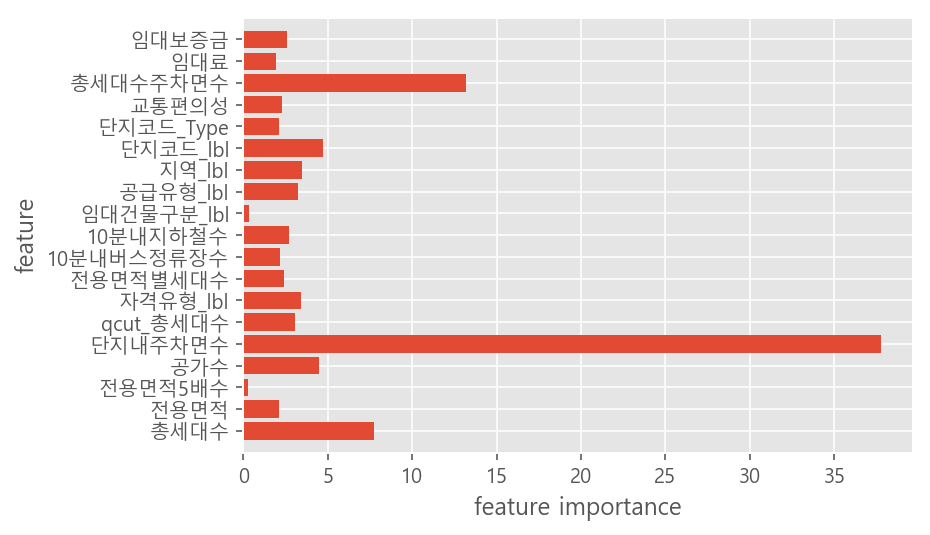

In [242]:
model_catboost_score(sel, train, test)
# model_catboost_score(sel, train, test)
# model_catboost_score(sel, train_ml, test_ml)

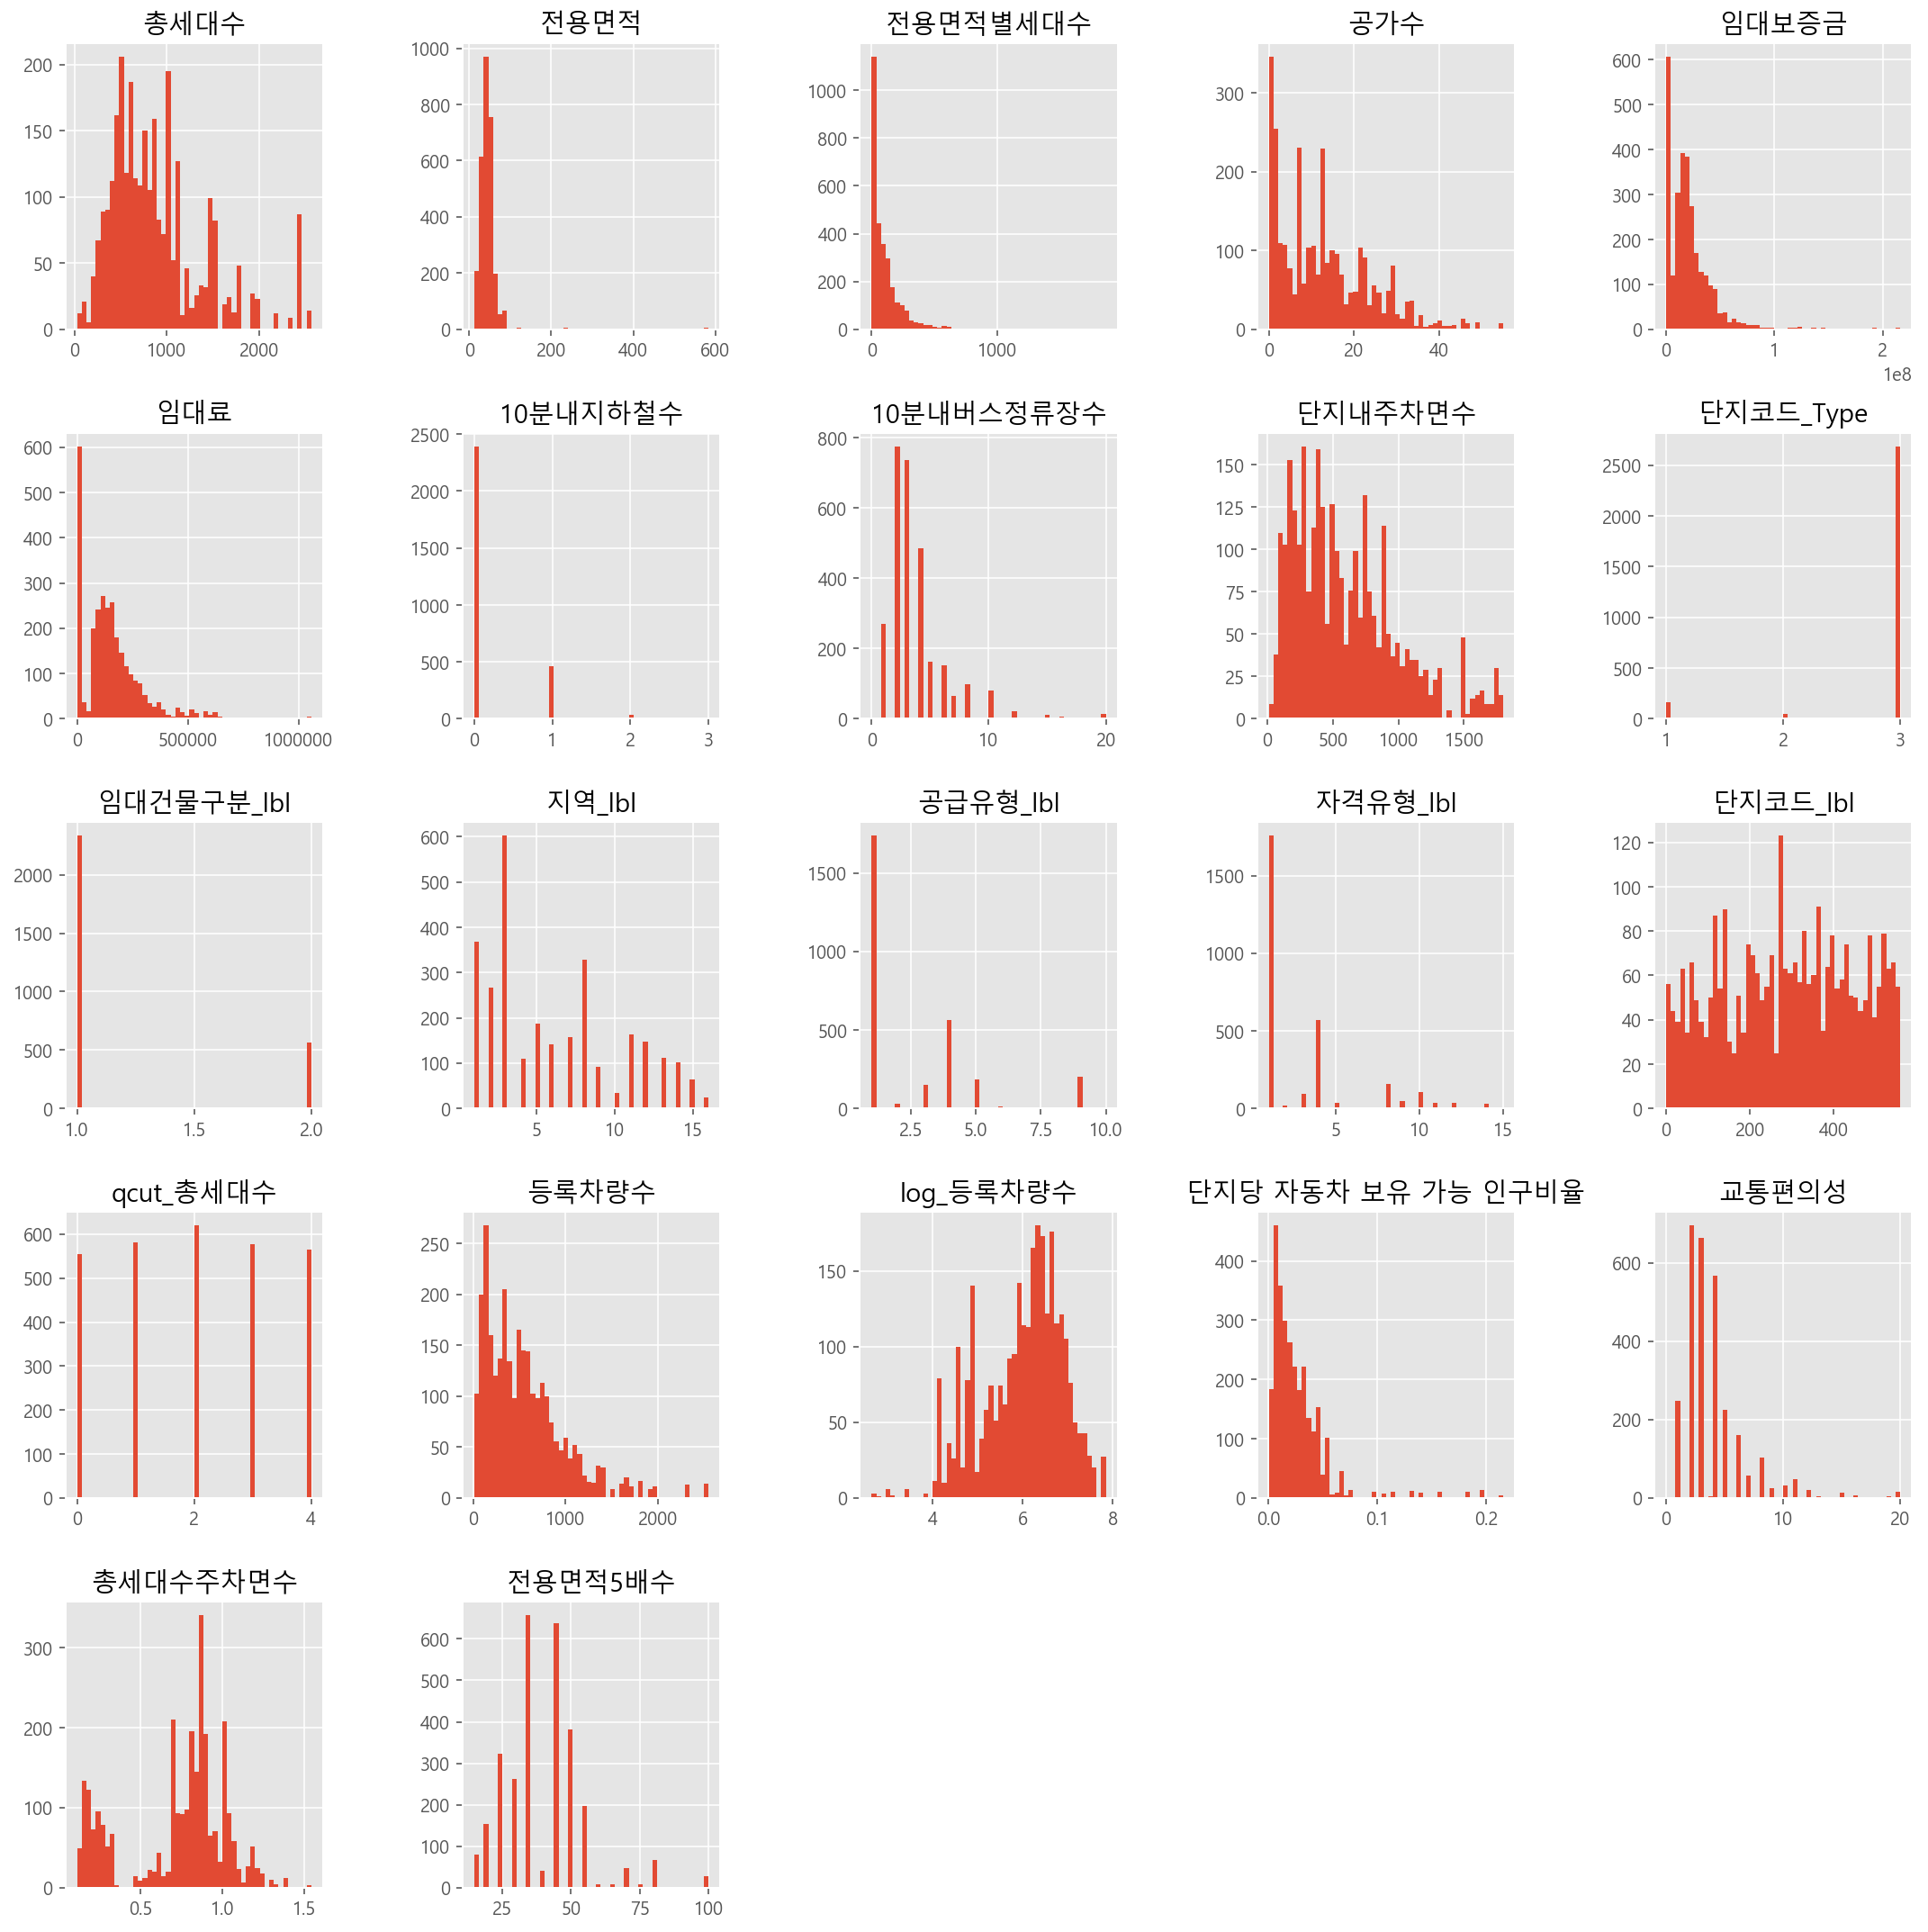

In [243]:
_ = train.hist(figsize=(15, 15), bins=50)
plt.tight_layout()

Train : 0.9689002063896195
Test : 0.9572092497188488
CatBoostRegressor Score : 0.10434721441993702

Train : 0.9689002063896195
Test : 0.9572092497188488
CatBoostRegressor Score : 0.10434721441993702

In [41]:
10434721441993702 == 10434721441993702

True

### cross_val_score 이용 사전 MAE 점수확인

In [42]:
model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

model.fit(X_train, y_train)

print('Train :', model.score(X_train,y_train))
print('Test :', model.score(X_test,y_test))

0:	learn: 311.7524850	total: 3.99ms	remaining: 1.99s
1:	learn: 300.9046694	total: 8.79ms	remaining: 2.19s
2:	learn: 291.1148439	total: 15.8ms	remaining: 2.63s
3:	learn: 279.9683233	total: 20.7ms	remaining: 2.56s
4:	learn: 269.7135390	total: 26.7ms	remaining: 2.65s
5:	learn: 260.8811051	total: 31ms	remaining: 2.56s
6:	learn: 251.7259324	total: 34.8ms	remaining: 2.45s
7:	learn: 243.1795923	total: 40.5ms	remaining: 2.49s
8:	learn: 235.6653745	total: 44.2ms	remaining: 2.41s
9:	learn: 228.5808192	total: 47.9ms	remaining: 2.35s
10:	learn: 222.2196819	total: 52.1ms	remaining: 2.31s
11:	learn: 215.4512703	total: 57.1ms	remaining: 2.32s
12:	learn: 208.7133630	total: 60.8ms	remaining: 2.28s
13:	learn: 202.5788760	total: 64.4ms	remaining: 2.23s
14:	learn: 196.7215068	total: 68.4ms	remaining: 2.21s
15:	learn: 190.3800027	total: 72.1ms	remaining: 2.18s
16:	learn: 185.1991637	total: 75.7ms	remaining: 2.15s
17:	learn: 179.7052044	total: 79.5ms	remaining: 2.13s
18:	learn: 175.3015472	total: 83.4ms	rem

159:	learn: 66.3334564	total: 685ms	remaining: 1.45s
160:	learn: 65.9473515	total: 689ms	remaining: 1.45s
161:	learn: 65.8611821	total: 692ms	remaining: 1.44s
162:	learn: 65.7604230	total: 697ms	remaining: 1.44s
163:	learn: 65.5242425	total: 700ms	remaining: 1.43s
164:	learn: 65.3954726	total: 704ms	remaining: 1.43s
165:	learn: 65.1311263	total: 708ms	remaining: 1.43s
166:	learn: 64.7884222	total: 714ms	remaining: 1.42s
167:	learn: 64.5799032	total: 717ms	remaining: 1.42s
168:	learn: 64.3650733	total: 721ms	remaining: 1.41s
169:	learn: 64.2868334	total: 725ms	remaining: 1.41s
170:	learn: 64.1378961	total: 729ms	remaining: 1.4s
171:	learn: 63.9475173	total: 733ms	remaining: 1.4s
172:	learn: 63.7780650	total: 736ms	remaining: 1.39s
173:	learn: 63.6189978	total: 742ms	remaining: 1.39s
174:	learn: 63.4807047	total: 746ms	remaining: 1.39s
175:	learn: 63.3050448	total: 749ms	remaining: 1.38s
176:	learn: 63.1541794	total: 753ms	remaining: 1.37s
177:	learn: 62.8791246	total: 758ms	remaining: 1

330:	learn: 48.8359571	total: 1.36s	remaining: 694ms
331:	learn: 48.7903389	total: 1.36s	remaining: 689ms
332:	learn: 48.7601068	total: 1.36s	remaining: 685ms
333:	learn: 48.6380578	total: 1.37s	remaining: 680ms
334:	learn: 48.5805053	total: 1.37s	remaining: 677ms
335:	learn: 48.4842900	total: 1.38s	remaining: 672ms
336:	learn: 48.3492168	total: 1.38s	remaining: 668ms
337:	learn: 48.3214434	total: 1.38s	remaining: 664ms
338:	learn: 48.2703875	total: 1.39s	remaining: 660ms
339:	learn: 48.2106384	total: 1.39s	remaining: 655ms
340:	learn: 47.9717439	total: 1.4s	remaining: 651ms
341:	learn: 47.8587392	total: 1.4s	remaining: 646ms
342:	learn: 47.6455157	total: 1.4s	remaining: 642ms
343:	learn: 47.6009745	total: 1.41s	remaining: 638ms
344:	learn: 47.5624813	total: 1.41s	remaining: 633ms
345:	learn: 47.5116829	total: 1.41s	remaining: 629ms
346:	learn: 47.3815994	total: 1.42s	remaining: 625ms
347:	learn: 47.2703040	total: 1.42s	remaining: 620ms
348:	learn: 47.2104680	total: 1.42s	remaining: 61

496:	learn: 41.2408066	total: 2.03s	remaining: 12.3ms
497:	learn: 41.2239828	total: 2.03s	remaining: 8.17ms
498:	learn: 41.2121522	total: 2.04s	remaining: 4.08ms
499:	learn: 41.1800289	total: 2.04s	remaining: 0us
Train : 0.9683249671669242
Test : 0.9582943809443134


In [43]:
now_time = time.time()

model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

model.fit(X_train, y_train)

score = cross_val_score(model, X_train, y_train,
                        cv=5, scoring="neg_mean_absolute_error") # neg_mean_squared_error
m_score = np.abs(score.mean())

print("CatBoostRegressor Score : {}".format(m_score))  # 점수

pro_time = time.time() - now_time
print('Time :', pro_time)  # 걸린 시간

0:	learn: 311.7524850	total: 3.5ms	remaining: 1.75s
1:	learn: 300.9046694	total: 7.12ms	remaining: 1.77s
2:	learn: 291.1148439	total: 10.4ms	remaining: 1.72s
3:	learn: 279.9683233	total: 13.6ms	remaining: 1.69s
4:	learn: 269.7135390	total: 17ms	remaining: 1.68s
5:	learn: 260.8811051	total: 21.3ms	remaining: 1.75s
6:	learn: 251.7259324	total: 25.5ms	remaining: 1.8s
7:	learn: 243.1795923	total: 29ms	remaining: 1.78s
8:	learn: 235.6653745	total: 34.7ms	remaining: 1.89s
9:	learn: 228.5808192	total: 38ms	remaining: 1.86s
10:	learn: 222.2196819	total: 41.2ms	remaining: 1.83s
11:	learn: 215.4512703	total: 46.6ms	remaining: 1.89s
12:	learn: 208.7133630	total: 59.4ms	remaining: 2.23s
13:	learn: 202.5788760	total: 73.3ms	remaining: 2.54s
14:	learn: 196.7215068	total: 84.7ms	remaining: 2.74s
15:	learn: 190.3800027	total: 96.8ms	remaining: 2.93s
16:	learn: 185.1991637	total: 105ms	remaining: 2.97s
17:	learn: 179.7052044	total: 115ms	remaining: 3.07s
18:	learn: 175.3015472	total: 125ms	remaining: 3

159:	learn: 66.3334564	total: 758ms	remaining: 1.61s
160:	learn: 65.9473515	total: 763ms	remaining: 1.6s
161:	learn: 65.8611821	total: 766ms	remaining: 1.6s
162:	learn: 65.7604230	total: 771ms	remaining: 1.59s
163:	learn: 65.5242425	total: 775ms	remaining: 1.59s
164:	learn: 65.3954726	total: 778ms	remaining: 1.58s
165:	learn: 65.1311263	total: 783ms	remaining: 1.58s
166:	learn: 64.7884222	total: 788ms	remaining: 1.57s
167:	learn: 64.5799032	total: 791ms	remaining: 1.56s
168:	learn: 64.3650733	total: 795ms	remaining: 1.56s
169:	learn: 64.2868334	total: 799ms	remaining: 1.55s
170:	learn: 64.1378961	total: 803ms	remaining: 1.54s
171:	learn: 63.9475173	total: 806ms	remaining: 1.54s
172:	learn: 63.7780650	total: 810ms	remaining: 1.53s
173:	learn: 63.6189978	total: 814ms	remaining: 1.52s
174:	learn: 63.4807047	total: 818ms	remaining: 1.52s
175:	learn: 63.3050448	total: 821ms	remaining: 1.51s
176:	learn: 63.1541794	total: 824ms	remaining: 1.5s
177:	learn: 62.8791246	total: 829ms	remaining: 1.

331:	learn: 48.7903389	total: 1.43s	remaining: 722ms
332:	learn: 48.7601068	total: 1.43s	remaining: 717ms
333:	learn: 48.6380578	total: 1.43s	remaining: 712ms
334:	learn: 48.5805053	total: 1.44s	remaining: 707ms
335:	learn: 48.4842900	total: 1.44s	remaining: 703ms
336:	learn: 48.3492168	total: 1.44s	remaining: 699ms
337:	learn: 48.3214434	total: 1.45s	remaining: 694ms
338:	learn: 48.2703875	total: 1.45s	remaining: 689ms
339:	learn: 48.2106384	total: 1.46s	remaining: 685ms
340:	learn: 47.9717439	total: 1.46s	remaining: 680ms
341:	learn: 47.8587392	total: 1.46s	remaining: 675ms
342:	learn: 47.6455157	total: 1.47s	remaining: 671ms
343:	learn: 47.6009745	total: 1.47s	remaining: 667ms
344:	learn: 47.5624813	total: 1.47s	remaining: 662ms
345:	learn: 47.5116829	total: 1.48s	remaining: 657ms
346:	learn: 47.3815994	total: 1.48s	remaining: 653ms
347:	learn: 47.2703040	total: 1.49s	remaining: 649ms
348:	learn: 47.2104680	total: 1.49s	remaining: 644ms
349:	learn: 47.1483068	total: 1.49s	remaining:

494:	learn: 41.2806334	total: 2.18s	remaining: 22.1ms
495:	learn: 41.2539261	total: 2.19s	remaining: 17.6ms
496:	learn: 41.2408066	total: 2.19s	remaining: 13.2ms
497:	learn: 41.2239828	total: 2.2s	remaining: 8.82ms
498:	learn: 41.2121522	total: 2.2s	remaining: 4.42ms
499:	learn: 41.1800289	total: 2.21s	remaining: 0us
0:	learn: 315.6961992	total: 3.46ms	remaining: 1.73s
1:	learn: 303.8755366	total: 6.84ms	remaining: 1.7s
2:	learn: 293.2397354	total: 21.2ms	remaining: 3.51s
3:	learn: 282.6518069	total: 24.8ms	remaining: 3.07s
4:	learn: 273.3562173	total: 28.6ms	remaining: 2.83s
5:	learn: 264.8155118	total: 32.4ms	remaining: 2.67s
6:	learn: 256.6036883	total: 50.5ms	remaining: 3.56s
7:	learn: 248.2902198	total: 53.5ms	remaining: 3.29s
8:	learn: 240.0227938	total: 56.8ms	remaining: 3.1s
9:	learn: 233.3149603	total: 61.3ms	remaining: 3s
10:	learn: 225.6257135	total: 64.9ms	remaining: 2.88s
11:	learn: 219.8715658	total: 68.5ms	remaining: 2.79s
12:	learn: 212.5796570	total: 71.7ms	remaining: 

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for mor

21:	learn: 164.7655580	total: 109ms	remaining: 2.36s
22:	learn: 161.2397348	total: 112ms	remaining: 2.32s
23:	learn: 157.8517641	total: 115ms	remaining: 2.27s
24:	learn: 155.4396612	total: 120ms	remaining: 2.29s
25:	learn: 152.1185634	total: 125ms	remaining: 2.29s
26:	learn: 149.1105776	total: 130ms	remaining: 2.27s
27:	learn: 146.8229776	total: 134ms	remaining: 2.26s
28:	learn: 144.0498879	total: 139ms	remaining: 2.25s
29:	learn: 141.6777610	total: 142ms	remaining: 2.22s
30:	learn: 139.1819420	total: 145ms	remaining: 2.2s
31:	learn: 137.3302066	total: 151ms	remaining: 2.21s
32:	learn: 134.8942340	total: 155ms	remaining: 2.19s
33:	learn: 133.4754810	total: 159ms	remaining: 2.18s
34:	learn: 131.5510740	total: 163ms	remaining: 2.17s
35:	learn: 129.2064820	total: 167ms	remaining: 2.16s
36:	learn: 127.5457226	total: 171ms	remaining: 2.14s
37:	learn: 125.9300050	total: 174ms	remaining: 2.12s
38:	learn: 124.7316113	total: 179ms	remaining: 2.12s
39:	learn: 123.4081905	total: 184ms	remaining: 

197:	learn: 59.9253681	total: 772ms	remaining: 1.18s
198:	learn: 59.6833051	total: 776ms	remaining: 1.17s
199:	learn: 59.5796344	total: 779ms	remaining: 1.17s
200:	learn: 59.3670784	total: 782ms	remaining: 1.16s
201:	learn: 59.2836996	total: 788ms	remaining: 1.16s
202:	learn: 59.1581003	total: 794ms	remaining: 1.16s
203:	learn: 58.8966592	total: 800ms	remaining: 1.16s
204:	learn: 58.7439907	total: 804ms	remaining: 1.16s
205:	learn: 58.5128857	total: 807ms	remaining: 1.15s
206:	learn: 58.4649446	total: 810ms	remaining: 1.15s
207:	learn: 58.2028643	total: 815ms	remaining: 1.14s
208:	learn: 58.0705120	total: 818ms	remaining: 1.14s
209:	learn: 57.8493412	total: 821ms	remaining: 1.13s
210:	learn: 57.5136275	total: 824ms	remaining: 1.13s
211:	learn: 57.4166084	total: 828ms	remaining: 1.12s
212:	learn: 57.0536221	total: 832ms	remaining: 1.12s
213:	learn: 56.8358986	total: 836ms	remaining: 1.12s
214:	learn: 56.5375553	total: 839ms	remaining: 1.11s
215:	learn: 56.4747618	total: 844ms	remaining:

360:	learn: 43.8724222	total: 1.43s	remaining: 552ms
361:	learn: 43.8248192	total: 1.44s	remaining: 548ms
362:	learn: 43.8073194	total: 1.44s	remaining: 544ms
363:	learn: 43.8029575	total: 1.44s	remaining: 540ms
364:	learn: 43.7817159	total: 1.45s	remaining: 536ms
365:	learn: 43.7662670	total: 1.45s	remaining: 532ms
366:	learn: 43.7376028	total: 1.46s	remaining: 527ms
367:	learn: 43.6790711	total: 1.46s	remaining: 523ms
368:	learn: 43.6706970	total: 1.47s	remaining: 520ms
369:	learn: 43.6575846	total: 1.47s	remaining: 516ms
370:	learn: 43.6186439	total: 1.47s	remaining: 512ms
371:	learn: 43.6099351	total: 1.48s	remaining: 508ms
372:	learn: 43.6035999	total: 1.48s	remaining: 504ms
373:	learn: 43.4865856	total: 1.48s	remaining: 500ms
374:	learn: 43.3480209	total: 1.49s	remaining: 496ms
375:	learn: 43.3443702	total: 1.49s	remaining: 491ms
376:	learn: 43.3158581	total: 1.49s	remaining: 487ms
377:	learn: 43.2390594	total: 1.5s	remaining: 483ms
378:	learn: 43.2228510	total: 1.5s	remaining: 4

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


29:	learn: 139.5283587	total: 109ms	remaining: 1.7s
30:	learn: 137.0490454	total: 112ms	remaining: 1.69s
31:	learn: 134.7510112	total: 116ms	remaining: 1.7s
32:	learn: 132.3762579	total: 120ms	remaining: 1.69s
33:	learn: 130.6432259	total: 123ms	remaining: 1.68s
34:	learn: 128.6929522	total: 127ms	remaining: 1.68s
35:	learn: 126.8528227	total: 131ms	remaining: 1.69s
36:	learn: 124.9965833	total: 134ms	remaining: 1.68s
37:	learn: 123.3242388	total: 138ms	remaining: 1.67s
38:	learn: 122.1408500	total: 141ms	remaining: 1.66s
39:	learn: 120.3746124	total: 145ms	remaining: 1.66s
40:	learn: 118.5532057	total: 148ms	remaining: 1.65s
41:	learn: 116.9736958	total: 151ms	remaining: 1.65s
42:	learn: 115.0517791	total: 154ms	remaining: 1.64s
43:	learn: 113.8844752	total: 159ms	remaining: 1.65s
44:	learn: 112.7037326	total: 163ms	remaining: 1.64s
45:	learn: 111.2756816	total: 166ms	remaining: 1.64s
46:	learn: 109.9914533	total: 170ms	remaining: 1.64s
47:	learn: 109.2391426	total: 173ms	remaining: 1

192:	learn: 60.2051048	total: 688ms	remaining: 1.09s
193:	learn: 60.0049012	total: 691ms	remaining: 1.09s
194:	learn: 59.8586725	total: 695ms	remaining: 1.09s
195:	learn: 59.7646178	total: 699ms	remaining: 1.08s
196:	learn: 59.6443439	total: 703ms	remaining: 1.08s
197:	learn: 59.5176452	total: 706ms	remaining: 1.08s
198:	learn: 59.4001703	total: 710ms	remaining: 1.07s
199:	learn: 59.2977879	total: 713ms	remaining: 1.07s
200:	learn: 59.1379589	total: 717ms	remaining: 1.07s
201:	learn: 59.1109122	total: 720ms	remaining: 1.06s
202:	learn: 58.9190901	total: 724ms	remaining: 1.06s
203:	learn: 58.4886774	total: 728ms	remaining: 1.06s
204:	learn: 58.4543706	total: 731ms	remaining: 1.05s
205:	learn: 58.3833766	total: 735ms	remaining: 1.05s
206:	learn: 58.0133709	total: 739ms	remaining: 1.04s
207:	learn: 57.5707887	total: 742ms	remaining: 1.04s
208:	learn: 57.3978144	total: 745ms	remaining: 1.04s
209:	learn: 57.2722869	total: 749ms	remaining: 1.03s
210:	learn: 57.2033207	total: 753ms	remaining:

359:	learn: 42.1412338	total: 1.35s	remaining: 527ms
360:	learn: 42.0826521	total: 1.36s	remaining: 523ms
361:	learn: 42.0677511	total: 1.36s	remaining: 519ms
362:	learn: 41.9766583	total: 1.36s	remaining: 515ms
363:	learn: 41.9576901	total: 1.37s	remaining: 511ms
364:	learn: 41.9551208	total: 1.37s	remaining: 507ms
365:	learn: 41.7771834	total: 1.38s	remaining: 504ms
366:	learn: 41.7423319	total: 1.38s	remaining: 500ms
367:	learn: 41.7131980	total: 1.38s	remaining: 496ms
368:	learn: 41.5255016	total: 1.39s	remaining: 492ms
369:	learn: 41.5067794	total: 1.39s	remaining: 489ms
370:	learn: 41.4780663	total: 1.39s	remaining: 485ms
371:	learn: 41.3827017	total: 1.4s	remaining: 481ms
372:	learn: 41.3225632	total: 1.4s	remaining: 477ms
373:	learn: 41.2937351	total: 1.4s	remaining: 473ms
374:	learn: 41.2198478	total: 1.41s	remaining: 469ms
375:	learn: 41.1521495	total: 1.41s	remaining: 465ms
376:	learn: 41.1014854	total: 1.41s	remaining: 461ms
377:	learn: 41.0700535	total: 1.42s	remaining: 45

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


32:	learn: 134.4398105	total: 116ms	remaining: 1.65s
33:	learn: 132.2583776	total: 120ms	remaining: 1.64s
34:	learn: 131.0238508	total: 123ms	remaining: 1.64s
35:	learn: 128.6448183	total: 127ms	remaining: 1.63s
36:	learn: 127.4328691	total: 130ms	remaining: 1.63s
37:	learn: 125.9388321	total: 133ms	remaining: 1.62s
38:	learn: 124.3449849	total: 137ms	remaining: 1.62s
39:	learn: 123.0169800	total: 140ms	remaining: 1.61s
40:	learn: 121.1398696	total: 144ms	remaining: 1.62s
41:	learn: 119.4947700	total: 148ms	remaining: 1.61s
42:	learn: 118.4871300	total: 151ms	remaining: 1.6s
43:	learn: 117.0341781	total: 154ms	remaining: 1.6s
44:	learn: 115.4463770	total: 158ms	remaining: 1.59s
45:	learn: 114.1934595	total: 162ms	remaining: 1.6s
46:	learn: 112.9330466	total: 165ms	remaining: 1.59s
47:	learn: 112.0005136	total: 169ms	remaining: 1.59s
48:	learn: 111.3471523	total: 172ms	remaining: 1.58s
49:	learn: 110.3584289	total: 177ms	remaining: 1.59s
50:	learn: 108.8952158	total: 180ms	remaining: 1.

192:	learn: 62.9885024	total: 696ms	remaining: 1.11s
193:	learn: 62.8804745	total: 700ms	remaining: 1.1s
194:	learn: 62.7996915	total: 702ms	remaining: 1.1s
195:	learn: 62.7282590	total: 707ms	remaining: 1.1s
196:	learn: 62.6130469	total: 710ms	remaining: 1.09s
197:	learn: 62.5518299	total: 713ms	remaining: 1.09s
198:	learn: 62.4925099	total: 717ms	remaining: 1.08s
199:	learn: 62.4424882	total: 720ms	remaining: 1.08s
200:	learn: 62.3324794	total: 724ms	remaining: 1.08s
201:	learn: 62.2848680	total: 727ms	remaining: 1.07s
202:	learn: 62.1606673	total: 730ms	remaining: 1.07s
203:	learn: 62.1045257	total: 733ms	remaining: 1.06s
204:	learn: 62.0382782	total: 737ms	remaining: 1.06s
205:	learn: 61.9909938	total: 740ms	remaining: 1.06s
206:	learn: 61.9734630	total: 743ms	remaining: 1.05s
207:	learn: 61.9166159	total: 746ms	remaining: 1.05s
208:	learn: 61.8665134	total: 750ms	remaining: 1.04s
209:	learn: 61.7564744	total: 753ms	remaining: 1.04s
210:	learn: 61.7180762	total: 756ms	remaining: 1.

364:	learn: 46.7463659	total: 1.36s	remaining: 504ms
365:	learn: 46.5818353	total: 1.37s	remaining: 500ms
366:	learn: 46.5207447	total: 1.37s	remaining: 497ms
367:	learn: 46.4107201	total: 1.37s	remaining: 493ms
368:	learn: 46.2015506	total: 1.38s	remaining: 489ms
369:	learn: 46.1863207	total: 1.38s	remaining: 485ms
370:	learn: 46.1528943	total: 1.39s	remaining: 482ms
371:	learn: 46.1471320	total: 1.39s	remaining: 478ms
372:	learn: 46.1374018	total: 1.39s	remaining: 475ms
373:	learn: 46.1344367	total: 1.4s	remaining: 471ms
374:	learn: 46.1295697	total: 1.4s	remaining: 467ms
375:	learn: 46.0550308	total: 1.4s	remaining: 463ms
376:	learn: 46.0513846	total: 1.41s	remaining: 459ms
377:	learn: 46.0179295	total: 1.41s	remaining: 455ms
378:	learn: 45.8895150	total: 1.41s	remaining: 452ms
379:	learn: 45.8237618	total: 1.42s	remaining: 448ms
380:	learn: 45.7797556	total: 1.42s	remaining: 445ms
381:	learn: 45.7595874	total: 1.43s	remaining: 441ms
382:	learn: 45.7515483	total: 1.43s	remaining: 43

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


18:	learn: 176.3249242	total: 76.6ms	remaining: 1.94s
19:	learn: 171.6244658	total: 80.4ms	remaining: 1.93s
20:	learn: 168.2590891	total: 84.1ms	remaining: 1.92s
21:	learn: 164.1942876	total: 88.5ms	remaining: 1.92s
22:	learn: 160.9118557	total: 91.9ms	remaining: 1.91s
23:	learn: 157.1605377	total: 95.1ms	remaining: 1.89s
24:	learn: 154.3019263	total: 98.9ms	remaining: 1.88s
25:	learn: 151.3296782	total: 103ms	remaining: 1.88s
26:	learn: 148.5278630	total: 107ms	remaining: 1.88s
27:	learn: 146.1198793	total: 111ms	remaining: 1.87s
28:	learn: 142.9345553	total: 115ms	remaining: 1.86s
29:	learn: 140.4900350	total: 118ms	remaining: 1.85s
30:	learn: 138.2809882	total: 122ms	remaining: 1.84s
31:	learn: 135.8659337	total: 125ms	remaining: 1.83s
32:	learn: 133.5578617	total: 130ms	remaining: 1.84s
33:	learn: 132.3425579	total: 134ms	remaining: 1.83s
34:	learn: 130.3316765	total: 137ms	remaining: 1.82s
35:	learn: 127.9989508	total: 141ms	remaining: 1.82s
36:	learn: 126.1761340	total: 146ms	rem

195:	learn: 59.1065954	total: 739ms	remaining: 1.15s
196:	learn: 58.8219291	total: 742ms	remaining: 1.14s
197:	learn: 58.4586073	total: 745ms	remaining: 1.14s
198:	learn: 58.1521305	total: 749ms	remaining: 1.13s
199:	learn: 57.8118027	total: 752ms	remaining: 1.13s
200:	learn: 57.5415360	total: 755ms	remaining: 1.12s
201:	learn: 57.3089281	total: 759ms	remaining: 1.12s
202:	learn: 57.2408453	total: 762ms	remaining: 1.11s
203:	learn: 57.1604247	total: 765ms	remaining: 1.11s
204:	learn: 56.9176676	total: 769ms	remaining: 1.11s
205:	learn: 56.8907676	total: 772ms	remaining: 1.1s
206:	learn: 56.8447424	total: 775ms	remaining: 1.1s
207:	learn: 56.6238750	total: 779ms	remaining: 1.09s
208:	learn: 56.4602097	total: 783ms	remaining: 1.09s
209:	learn: 56.3567838	total: 786ms	remaining: 1.08s
210:	learn: 56.2297248	total: 789ms	remaining: 1.08s
211:	learn: 56.1014586	total: 793ms	remaining: 1.08s
212:	learn: 55.8156181	total: 796ms	remaining: 1.07s
213:	learn: 55.7050542	total: 799ms	remaining: 1

358:	learn: 42.6984768	total: 1.33s	remaining: 522ms
359:	learn: 42.6672732	total: 1.33s	remaining: 518ms
360:	learn: 42.6608949	total: 1.33s	remaining: 514ms
361:	learn: 42.5779579	total: 1.34s	remaining: 511ms
362:	learn: 42.5340154	total: 1.34s	remaining: 507ms
363:	learn: 42.4928496	total: 1.35s	remaining: 503ms
364:	learn: 42.4678934	total: 1.35s	remaining: 499ms
365:	learn: 42.3974517	total: 1.35s	remaining: 496ms
366:	learn: 42.3409185	total: 1.36s	remaining: 492ms
367:	learn: 42.1424505	total: 1.36s	remaining: 488ms
368:	learn: 42.0805708	total: 1.36s	remaining: 484ms
369:	learn: 41.9805814	total: 1.37s	remaining: 481ms
370:	learn: 41.9080259	total: 1.37s	remaining: 477ms
371:	learn: 41.8470269	total: 1.37s	remaining: 473ms
372:	learn: 41.7794336	total: 1.38s	remaining: 469ms
373:	learn: 41.7264212	total: 1.38s	remaining: 466ms
374:	learn: 41.5825837	total: 1.39s	remaining: 462ms
375:	learn: 41.5381505	total: 1.39s	remaining: 458ms
376:	learn: 41.4370561	total: 1.39s	remaining:

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


23:	learn: 157.7916517	total: 81ms	remaining: 1.61s
24:	learn: 154.6903376	total: 84.2ms	remaining: 1.6s
25:	learn: 151.4551279	total: 87.2ms	remaining: 1.59s
26:	learn: 148.7063937	total: 91.3ms	remaining: 1.6s
27:	learn: 145.9046794	total: 94.8ms	remaining: 1.6s
28:	learn: 142.9726897	total: 97.9ms	remaining: 1.59s
29:	learn: 140.6138500	total: 101ms	remaining: 1.59s
30:	learn: 138.0991189	total: 105ms	remaining: 1.59s
31:	learn: 136.1188315	total: 109ms	remaining: 1.59s
32:	learn: 133.7183810	total: 112ms	remaining: 1.58s
33:	learn: 131.1496403	total: 115ms	remaining: 1.57s
34:	learn: 129.2486822	total: 119ms	remaining: 1.58s
35:	learn: 127.0025758	total: 122ms	remaining: 1.58s
36:	learn: 125.5973703	total: 125ms	remaining: 1.56s
37:	learn: 123.7344459	total: 128ms	remaining: 1.55s
38:	learn: 122.5581649	total: 131ms	remaining: 1.54s
39:	learn: 120.8205510	total: 135ms	remaining: 1.55s
40:	learn: 119.5495331	total: 138ms	remaining: 1.54s
41:	learn: 117.5268007	total: 140ms	remaining

191:	learn: 59.6146490	total: 750ms	remaining: 1.2s
192:	learn: 59.4614626	total: 753ms	remaining: 1.2s
193:	learn: 59.0885715	total: 757ms	remaining: 1.19s
194:	learn: 58.9529268	total: 760ms	remaining: 1.19s
195:	learn: 58.8967741	total: 763ms	remaining: 1.18s
196:	learn: 58.7317326	total: 767ms	remaining: 1.18s
197:	learn: 58.5344665	total: 770ms	remaining: 1.17s
198:	learn: 58.5103278	total: 774ms	remaining: 1.17s
199:	learn: 58.3942237	total: 777ms	remaining: 1.17s
200:	learn: 58.1582408	total: 781ms	remaining: 1.16s
201:	learn: 57.8011217	total: 785ms	remaining: 1.16s
202:	learn: 57.6967774	total: 791ms	remaining: 1.16s
203:	learn: 57.6667192	total: 794ms	remaining: 1.15s
204:	learn: 57.4546881	total: 798ms	remaining: 1.15s
205:	learn: 57.4204082	total: 801ms	remaining: 1.14s
206:	learn: 57.2246910	total: 805ms	remaining: 1.14s
207:	learn: 57.1102291	total: 809ms	remaining: 1.14s
208:	learn: 56.9344418	total: 814ms	remaining: 1.13s
209:	learn: 56.8370768	total: 818ms	remaining: 1

359:	learn: 46.2885237	total: 1.42s	remaining: 551ms
360:	learn: 46.1975876	total: 1.42s	remaining: 547ms
361:	learn: 46.0924449	total: 1.42s	remaining: 543ms
362:	learn: 46.0450597	total: 1.43s	remaining: 539ms
363:	learn: 45.9744182	total: 1.43s	remaining: 535ms
364:	learn: 45.9346633	total: 1.43s	remaining: 531ms
365:	learn: 45.8598571	total: 1.44s	remaining: 527ms
366:	learn: 45.8499408	total: 1.44s	remaining: 523ms
367:	learn: 45.8270760	total: 1.45s	remaining: 519ms
368:	learn: 45.5329907	total: 1.45s	remaining: 514ms
369:	learn: 45.4845764	total: 1.45s	remaining: 510ms
370:	learn: 45.4708258	total: 1.46s	remaining: 507ms
371:	learn: 45.4309387	total: 1.46s	remaining: 503ms
372:	learn: 45.3193405	total: 1.47s	remaining: 499ms
373:	learn: 45.2997476	total: 1.47s	remaining: 496ms
374:	learn: 45.2687879	total: 1.48s	remaining: 492ms
375:	learn: 45.2368837	total: 1.48s	remaining: 488ms
376:	learn: 45.2198597	total: 1.48s	remaining: 484ms
377:	learn: 45.2092594	total: 1.49s	remaining:

(-1, 18)

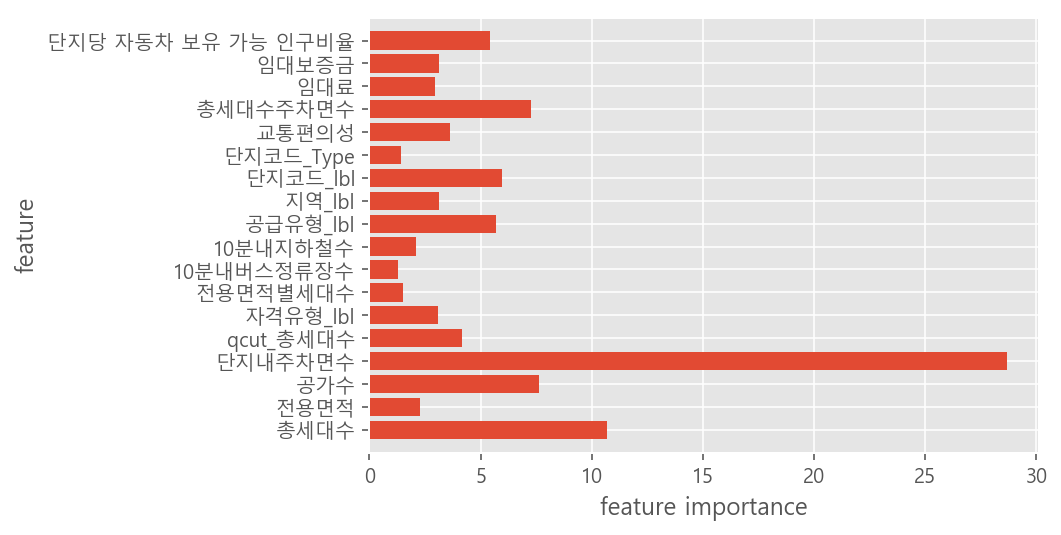

In [44]:
imp = model.feature_importances_                   # feature의 중요도
n_features = len(sel)
feature_names = sel
plt.barh(range(n_features) , imp, align='center')  # 그래프(가로 막대 그래프)
plt.yticks(np.arange(n_features), feature_names)   # y축 값 지정
plt.xlabel("feature importance")
plt.ylabel("feature")
plt.ylim(-1, n_features)

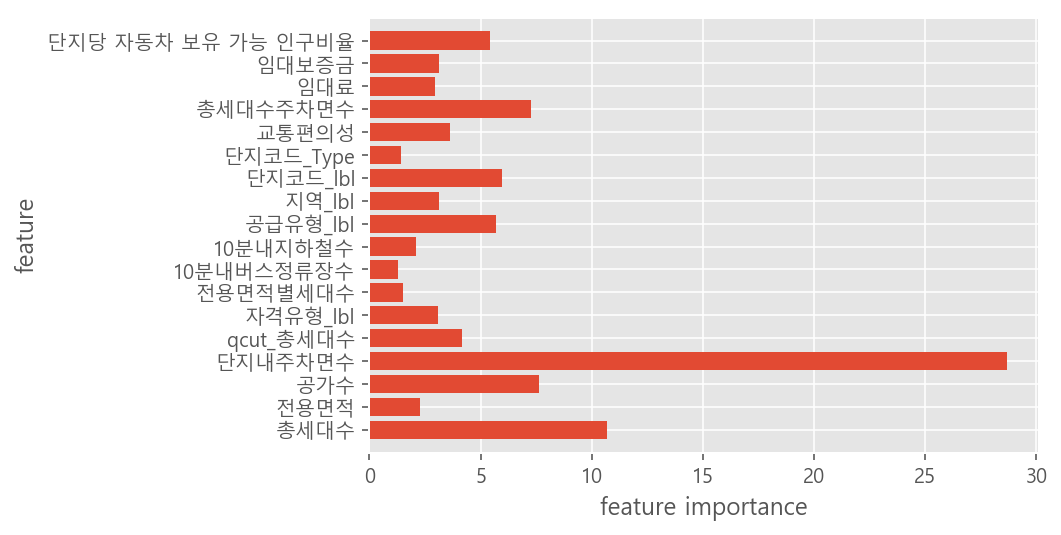

In [45]:
plot_feature_important_common(model, sel)

In [46]:
# X = train_ml[sel]
# y = train_ml['log_등록차량수']
# test_X = test_ml[sel]

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### cross_val_score 이용 사전 MAE 점수확인

In [47]:
model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

model.fit(X_train, y_train)

print('Train :', model.score(X_train,y_train))
print('Train :', model.score(X_test,y_test))

0:	learn: 311.7524850	total: 5.8ms	remaining: 2.9s
1:	learn: 300.9046694	total: 9.2ms	remaining: 2.29s
2:	learn: 291.1148439	total: 13.2ms	remaining: 2.19s
3:	learn: 279.9683233	total: 17.8ms	remaining: 2.21s
4:	learn: 269.7135390	total: 21.5ms	remaining: 2.13s
5:	learn: 260.8811051	total: 25.5ms	remaining: 2.1s
6:	learn: 251.7259324	total: 29.9ms	remaining: 2.1s
7:	learn: 243.1795923	total: 33.9ms	remaining: 2.08s
8:	learn: 235.6653745	total: 37.5ms	remaining: 2.05s
9:	learn: 228.5808192	total: 41ms	remaining: 2.01s
10:	learn: 222.2196819	total: 46.1ms	remaining: 2.05s
11:	learn: 215.4512703	total: 50.2ms	remaining: 2.04s
12:	learn: 208.7133630	total: 53.9ms	remaining: 2.02s
13:	learn: 202.5788760	total: 57.7ms	remaining: 2s
14:	learn: 196.7215068	total: 65.7ms	remaining: 2.12s
15:	learn: 190.3800027	total: 70.3ms	remaining: 2.13s
16:	learn: 185.1991637	total: 74.6ms	remaining: 2.12s
17:	learn: 179.7052044	total: 78.4ms	remaining: 2.1s
18:	learn: 175.3015472	total: 81.8ms	remaining: 2

160:	learn: 65.9473515	total: 677ms	remaining: 1.43s
161:	learn: 65.8611821	total: 680ms	remaining: 1.42s
162:	learn: 65.7604230	total: 685ms	remaining: 1.42s
163:	learn: 65.5242425	total: 688ms	remaining: 1.41s
164:	learn: 65.3954726	total: 692ms	remaining: 1.4s
165:	learn: 65.1311263	total: 696ms	remaining: 1.4s
166:	learn: 64.7884222	total: 700ms	remaining: 1.4s
167:	learn: 64.5799032	total: 704ms	remaining: 1.39s
168:	learn: 64.3650733	total: 708ms	remaining: 1.39s
169:	learn: 64.2868334	total: 711ms	remaining: 1.38s
170:	learn: 64.1378961	total: 715ms	remaining: 1.37s
171:	learn: 63.9475173	total: 718ms	remaining: 1.37s
172:	learn: 63.7780650	total: 721ms	remaining: 1.36s
173:	learn: 63.6189978	total: 724ms	remaining: 1.36s
174:	learn: 63.4807047	total: 729ms	remaining: 1.35s
175:	learn: 63.3050448	total: 732ms	remaining: 1.35s
176:	learn: 63.1541794	total: 736ms	remaining: 1.34s
177:	learn: 62.8791246	total: 739ms	remaining: 1.34s
178:	learn: 62.7579684	total: 744ms	remaining: 1.

339:	learn: 48.2106384	total: 1.34s	remaining: 632ms
340:	learn: 47.9717439	total: 1.35s	remaining: 628ms
341:	learn: 47.8587392	total: 1.35s	remaining: 624ms
342:	learn: 47.6455157	total: 1.35s	remaining: 620ms
343:	learn: 47.6009745	total: 1.36s	remaining: 616ms
344:	learn: 47.5624813	total: 1.36s	remaining: 611ms
345:	learn: 47.5116829	total: 1.36s	remaining: 607ms
346:	learn: 47.3815994	total: 1.37s	remaining: 603ms
347:	learn: 47.2703040	total: 1.37s	remaining: 599ms
348:	learn: 47.2104680	total: 1.38s	remaining: 595ms
349:	learn: 47.1483068	total: 1.38s	remaining: 592ms
350:	learn: 47.0457679	total: 1.38s	remaining: 588ms
351:	learn: 47.0297831	total: 1.39s	remaining: 584ms
352:	learn: 46.8946369	total: 1.39s	remaining: 580ms
353:	learn: 46.7020710	total: 1.4s	remaining: 576ms
354:	learn: 46.6671269	total: 1.4s	remaining: 572ms
355:	learn: 46.5718782	total: 1.42s	remaining: 574ms
356:	learn: 46.5309141	total: 1.42s	remaining: 570ms
357:	learn: 46.4566403	total: 1.43s	remaining: 5

Train : 0.9683249671669242
Train : 0.9582943809443134


In [48]:
now_time = time.time()

model = CatBoostRegressor(loss_function='MAE',
                          n_estimators=500, 
                          learning_rate=0.05, 
                          random_state=42)

model.fit(X_train, y_train)

score = cross_val_score(model, X_train, y_train,
                        cv=5, scoring="neg_mean_absolute_error") # neg_mean_squared_error
m_score = np.abs(score.mean())

print("CatBoostRegressor Score : {}".format(m_score))  # 점수

pro_time = time.time() - now_time
print('Time :', pro_time)  # 걸린 시간

0:	learn: 311.7524850	total: 3.92ms	remaining: 1.96s
1:	learn: 300.9046694	total: 7.85ms	remaining: 1.95s
2:	learn: 291.1148439	total: 12.1ms	remaining: 2s
3:	learn: 279.9683233	total: 15.6ms	remaining: 1.93s
4:	learn: 269.7135390	total: 19.1ms	remaining: 1.89s
5:	learn: 260.8811051	total: 23ms	remaining: 1.9s
6:	learn: 251.7259324	total: 27.1ms	remaining: 1.91s
7:	learn: 243.1795923	total: 30.7ms	remaining: 1.89s
8:	learn: 235.6653745	total: 34.4ms	remaining: 1.88s
9:	learn: 228.5808192	total: 38.4ms	remaining: 1.88s
10:	learn: 222.2196819	total: 41.8ms	remaining: 1.86s
11:	learn: 215.4512703	total: 45.3ms	remaining: 1.84s
12:	learn: 208.7133630	total: 49.4ms	remaining: 1.85s
13:	learn: 202.5788760	total: 54.5ms	remaining: 1.89s
14:	learn: 196.7215068	total: 58.7ms	remaining: 1.9s
15:	learn: 190.3800027	total: 62.6ms	remaining: 1.89s
16:	learn: 185.1991637	total: 66.4ms	remaining: 1.89s
17:	learn: 179.7052044	total: 71.1ms	remaining: 1.9s
18:	learn: 175.3015472	total: 74.5ms	remaining

171:	learn: 63.9475173	total: 794ms	remaining: 1.51s
172:	learn: 63.7780650	total: 798ms	remaining: 1.51s
173:	learn: 63.6189978	total: 803ms	remaining: 1.5s
174:	learn: 63.4807047	total: 807ms	remaining: 1.5s
175:	learn: 63.3050448	total: 810ms	remaining: 1.49s
176:	learn: 63.1541794	total: 814ms	remaining: 1.48s
177:	learn: 62.8791246	total: 819ms	remaining: 1.48s
178:	learn: 62.7579684	total: 822ms	remaining: 1.47s
179:	learn: 62.6481612	total: 825ms	remaining: 1.47s
180:	learn: 62.3845124	total: 828ms	remaining: 1.46s
181:	learn: 62.2560804	total: 833ms	remaining: 1.46s
182:	learn: 62.2121286	total: 836ms	remaining: 1.45s
183:	learn: 62.0227514	total: 840ms	remaining: 1.44s
184:	learn: 61.9595986	total: 844ms	remaining: 1.44s
185:	learn: 61.8304465	total: 849ms	remaining: 1.43s
186:	learn: 61.7836003	total: 852ms	remaining: 1.43s
187:	learn: 61.6923486	total: 856ms	remaining: 1.42s
188:	learn: 61.5337926	total: 862ms	remaining: 1.42s
189:	learn: 61.4638973	total: 865ms	remaining: 1

335:	learn: 48.4842900	total: 1.47s	remaining: 716ms
336:	learn: 48.3492168	total: 1.47s	remaining: 711ms
337:	learn: 48.3214434	total: 1.47s	remaining: 706ms
338:	learn: 48.2703875	total: 1.48s	remaining: 702ms
339:	learn: 48.2106384	total: 1.48s	remaining: 697ms
340:	learn: 47.9717439	total: 1.48s	remaining: 692ms
341:	learn: 47.8587392	total: 1.49s	remaining: 688ms
342:	learn: 47.6455157	total: 1.49s	remaining: 683ms
343:	learn: 47.6009745	total: 1.5s	remaining: 679ms
344:	learn: 47.5624813	total: 1.5s	remaining: 674ms
345:	learn: 47.5116829	total: 1.5s	remaining: 669ms
346:	learn: 47.3815994	total: 1.51s	remaining: 665ms
347:	learn: 47.2703040	total: 1.51s	remaining: 661ms
348:	learn: 47.2104680	total: 1.52s	remaining: 656ms
349:	learn: 47.1483068	total: 1.52s	remaining: 652ms
350:	learn: 47.0457679	total: 1.52s	remaining: 647ms
351:	learn: 47.0297831	total: 1.53s	remaining: 642ms
352:	learn: 46.8946369	total: 1.53s	remaining: 638ms
353:	learn: 46.7020710	total: 1.53s	remaining: 63

0:	learn: 315.6961992	total: 17.1ms	remaining: 8.52s
1:	learn: 303.8755366	total: 20.2ms	remaining: 5.03s


C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for mor

2:	learn: 293.2397354	total: 23.7ms	remaining: 3.93s
3:	learn: 282.6518069	total: 27.3ms	remaining: 3.38s
4:	learn: 273.3562173	total: 30.6ms	remaining: 3.03s
5:	learn: 264.8155118	total: 34ms	remaining: 2.8s
6:	learn: 256.6036883	total: 37.3ms	remaining: 2.62s
7:	learn: 248.2902198	total: 40.6ms	remaining: 2.5s
8:	learn: 240.0227938	total: 44.3ms	remaining: 2.42s
9:	learn: 233.3149603	total: 48ms	remaining: 2.35s
10:	learn: 225.6257135	total: 51.4ms	remaining: 2.28s
11:	learn: 219.8715658	total: 54.9ms	remaining: 2.23s
12:	learn: 212.5796570	total: 58.3ms	remaining: 2.18s
13:	learn: 205.5182033	total: 61.7ms	remaining: 2.14s
14:	learn: 199.5199049	total: 64.9ms	remaining: 2.1s
15:	learn: 193.2241749	total: 68.2ms	remaining: 2.06s
16:	learn: 187.2088287	total: 71.5ms	remaining: 2.03s
17:	learn: 181.6184550	total: 74.6ms	remaining: 2s
18:	learn: 177.1533962	total: 77.7ms	remaining: 1.97s
19:	learn: 171.9656757	total: 80.9ms	remaining: 1.94s
20:	learn: 168.8072326	total: 84.5ms	remaining

187:	learn: 61.9093889	total: 676ms	remaining: 1.12s
188:	learn: 61.4561399	total: 679ms	remaining: 1.12s
189:	learn: 61.3363593	total: 683ms	remaining: 1.11s
190:	learn: 61.1929319	total: 686ms	remaining: 1.11s
191:	learn: 61.0834730	total: 690ms	remaining: 1.11s
192:	learn: 60.8498615	total: 693ms	remaining: 1.1s
193:	learn: 60.7940434	total: 696ms	remaining: 1.1s
194:	learn: 60.6075625	total: 699ms	remaining: 1.09s
195:	learn: 60.1428069	total: 703ms	remaining: 1.09s
196:	learn: 60.0306502	total: 706ms	remaining: 1.08s
197:	learn: 59.9253681	total: 709ms	remaining: 1.08s
198:	learn: 59.6833051	total: 712ms	remaining: 1.08s
199:	learn: 59.5796344	total: 715ms	remaining: 1.07s
200:	learn: 59.3670784	total: 718ms	remaining: 1.07s
201:	learn: 59.2836996	total: 721ms	remaining: 1.06s
202:	learn: 59.1581003	total: 724ms	remaining: 1.06s
203:	learn: 58.8966592	total: 727ms	remaining: 1.05s
204:	learn: 58.7439907	total: 730ms	remaining: 1.05s
205:	learn: 58.5128857	total: 733ms	remaining: 1

384:	learn: 43.0826021	total: 1.34s	remaining: 401ms
385:	learn: 43.0650649	total: 1.34s	remaining: 397ms
386:	learn: 42.9774173	total: 1.35s	remaining: 394ms
387:	learn: 42.9365464	total: 1.35s	remaining: 391ms
388:	learn: 42.9259096	total: 1.36s	remaining: 387ms
389:	learn: 42.8383185	total: 1.36s	remaining: 384ms
390:	learn: 42.6830749	total: 1.36s	remaining: 380ms
391:	learn: 42.6369361	total: 1.37s	remaining: 377ms
392:	learn: 42.6171781	total: 1.37s	remaining: 373ms
393:	learn: 42.5555226	total: 1.37s	remaining: 370ms
394:	learn: 42.5427935	total: 1.38s	remaining: 366ms
395:	learn: 42.5336422	total: 1.38s	remaining: 363ms
396:	learn: 42.4186782	total: 1.38s	remaining: 359ms
397:	learn: 42.3705688	total: 1.39s	remaining: 355ms
398:	learn: 42.3033688	total: 1.39s	remaining: 352ms
399:	learn: 42.2979116	total: 1.39s	remaining: 348ms
400:	learn: 42.1990441	total: 1.4s	remaining: 345ms
401:	learn: 42.1844328	total: 1.4s	remaining: 341ms
402:	learn: 42.1707760	total: 1.4s	remaining: 33

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


1:	learn: 295.2741596	total: 8.48ms	remaining: 2.11s
2:	learn: 285.7597631	total: 12.6ms	remaining: 2.09s
3:	learn: 275.2259660	total: 16.6ms	remaining: 2.06s
4:	learn: 266.3888713	total: 21.1ms	remaining: 2.08s
5:	learn: 258.0016388	total: 25.7ms	remaining: 2.12s
6:	learn: 248.9009320	total: 30ms	remaining: 2.11s
7:	learn: 241.7447402	total: 34ms	remaining: 2.09s
8:	learn: 234.4285564	total: 39.2ms	remaining: 2.14s
9:	learn: 227.3727916	total: 43.4ms	remaining: 2.13s
10:	learn: 220.8435673	total: 47.6ms	remaining: 2.12s
11:	learn: 214.0289118	total: 51.1ms	remaining: 2.08s
12:	learn: 207.5754874	total: 55.1ms	remaining: 2.06s
13:	learn: 201.6785386	total: 59ms	remaining: 2.05s
14:	learn: 195.7249491	total: 62.6ms	remaining: 2.02s
15:	learn: 189.0811412	total: 66.6ms	remaining: 2.01s
16:	learn: 183.1075370	total: 70ms	remaining: 1.99s
17:	learn: 178.6298635	total: 73.8ms	remaining: 1.98s
18:	learn: 173.6380370	total: 81.9ms	remaining: 2.07s
19:	learn: 169.0489128	total: 85.7ms	remainin

174:	learn: 63.4536965	total: 667ms	remaining: 1.24s
175:	learn: 63.0307012	total: 670ms	remaining: 1.23s
176:	learn: 62.8724219	total: 674ms	remaining: 1.23s
177:	learn: 62.8399563	total: 677ms	remaining: 1.22s
178:	learn: 62.6166477	total: 681ms	remaining: 1.22s
179:	learn: 62.4760100	total: 685ms	remaining: 1.22s
180:	learn: 62.0783539	total: 688ms	remaining: 1.21s
181:	learn: 61.7721298	total: 691ms	remaining: 1.21s
182:	learn: 61.6818215	total: 695ms	remaining: 1.2s
183:	learn: 61.5905329	total: 697ms	remaining: 1.2s
184:	learn: 61.4037557	total: 700ms	remaining: 1.19s
185:	learn: 61.2714117	total: 704ms	remaining: 1.19s
186:	learn: 61.1243629	total: 707ms	remaining: 1.18s
187:	learn: 60.8630192	total: 710ms	remaining: 1.18s
188:	learn: 60.7405862	total: 714ms	remaining: 1.17s
189:	learn: 60.5906387	total: 717ms	remaining: 1.17s
190:	learn: 60.4469069	total: 721ms	remaining: 1.17s
191:	learn: 60.4206317	total: 724ms	remaining: 1.16s
192:	learn: 60.2051048	total: 728ms	remaining: 1

366:	learn: 41.7423319	total: 1.33s	remaining: 482ms
367:	learn: 41.7131980	total: 1.33s	remaining: 479ms
368:	learn: 41.5255016	total: 1.34s	remaining: 475ms
369:	learn: 41.5067794	total: 1.34s	remaining: 472ms
370:	learn: 41.4780663	total: 1.35s	remaining: 469ms
371:	learn: 41.3827017	total: 1.35s	remaining: 466ms
372:	learn: 41.3225632	total: 1.36s	remaining: 464ms
373:	learn: 41.2937351	total: 1.36s	remaining: 460ms
374:	learn: 41.2198478	total: 1.37s	remaining: 457ms
375:	learn: 41.1521495	total: 1.38s	remaining: 454ms
376:	learn: 41.1014854	total: 1.38s	remaining: 451ms
377:	learn: 41.0700535	total: 1.39s	remaining: 447ms
378:	learn: 41.0302976	total: 1.39s	remaining: 444ms
379:	learn: 40.9886476	total: 1.39s	remaining: 440ms
380:	learn: 40.9282788	total: 1.4s	remaining: 437ms
381:	learn: 40.8651851	total: 1.4s	remaining: 433ms
382:	learn: 40.8280436	total: 1.4s	remaining: 429ms
383:	learn: 40.7419998	total: 1.41s	remaining: 426ms
384:	learn: 40.6922066	total: 1.41s	remaining: 42

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


23:	learn: 159.4199278	total: 91.6ms	remaining: 1.82s
24:	learn: 156.0483297	total: 95.1ms	remaining: 1.81s
25:	learn: 153.2509051	total: 99.4ms	remaining: 1.81s
26:	learn: 150.0842484	total: 103ms	remaining: 1.8s
27:	learn: 147.1698713	total: 107ms	remaining: 1.8s
28:	learn: 145.0299854	total: 112ms	remaining: 1.81s
29:	learn: 142.2597809	total: 116ms	remaining: 1.81s
30:	learn: 139.1888710	total: 120ms	remaining: 1.82s
31:	learn: 136.8768617	total: 125ms	remaining: 1.82s
32:	learn: 134.4398105	total: 128ms	remaining: 1.81s
33:	learn: 132.2583776	total: 132ms	remaining: 1.81s
34:	learn: 131.0238508	total: 137ms	remaining: 1.83s
35:	learn: 128.6448183	total: 141ms	remaining: 1.81s
36:	learn: 127.4328691	total: 144ms	remaining: 1.8s
37:	learn: 125.9388321	total: 148ms	remaining: 1.79s
38:	learn: 124.3449849	total: 151ms	remaining: 1.79s
39:	learn: 123.0169800	total: 155ms	remaining: 1.78s
40:	learn: 121.1398696	total: 158ms	remaining: 1.76s
41:	learn: 119.4947700	total: 162ms	remaining:

212:	learn: 61.6117067	total: 753ms	remaining: 1.01s
213:	learn: 61.5225271	total: 756ms	remaining: 1.01s
214:	learn: 61.3654796	total: 759ms	remaining: 1s
215:	learn: 61.2724579	total: 762ms	remaining: 1s
216:	learn: 61.1518574	total: 765ms	remaining: 997ms
217:	learn: 61.1184890	total: 768ms	remaining: 994ms
218:	learn: 60.9979654	total: 771ms	remaining: 989ms
219:	learn: 60.8021766	total: 774ms	remaining: 986ms
220:	learn: 60.6543447	total: 778ms	remaining: 982ms
221:	learn: 60.6043318	total: 781ms	remaining: 978ms
222:	learn: 60.4407197	total: 785ms	remaining: 975ms
223:	learn: 60.2880596	total: 788ms	remaining: 971ms
224:	learn: 60.2220912	total: 791ms	remaining: 966ms
225:	learn: 60.1644924	total: 794ms	remaining: 962ms
226:	learn: 59.9889773	total: 797ms	remaining: 958ms
227:	learn: 59.7924622	total: 800ms	remaining: 954ms
228:	learn: 59.6324986	total: 803ms	remaining: 950ms
229:	learn: 59.5668860	total: 806ms	remaining: 946ms
230:	learn: 59.4771670	total: 809ms	remaining: 942ms

408:	learn: 44.4339754	total: 1.42s	remaining: 315ms
409:	learn: 44.4263363	total: 1.42s	remaining: 312ms
410:	learn: 44.4235579	total: 1.42s	remaining: 308ms
411:	learn: 44.3526083	total: 1.43s	remaining: 305ms
412:	learn: 44.3069043	total: 1.43s	remaining: 301ms
413:	learn: 44.2872750	total: 1.43s	remaining: 298ms
414:	learn: 44.1651141	total: 1.44s	remaining: 294ms
415:	learn: 44.1315920	total: 1.44s	remaining: 291ms
416:	learn: 44.0902591	total: 1.44s	remaining: 287ms
417:	learn: 44.0688666	total: 1.45s	remaining: 284ms
418:	learn: 44.0334087	total: 1.45s	remaining: 280ms
419:	learn: 44.0084172	total: 1.45s	remaining: 277ms
420:	learn: 43.9795930	total: 1.46s	remaining: 273ms
421:	learn: 43.9267233	total: 1.46s	remaining: 270ms
422:	learn: 43.9245163	total: 1.46s	remaining: 266ms
423:	learn: 43.8902366	total: 1.47s	remaining: 263ms
424:	learn: 43.8603016	total: 1.47s	remaining: 259ms
425:	learn: 43.8163725	total: 1.47s	remaining: 256ms
426:	learn: 43.8018335	total: 1.48s	remaining:

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


1:	learn: 299.3006373	total: 7.91ms	remaining: 1.97s
2:	learn: 289.6648524	total: 13.2ms	remaining: 2.19s
3:	learn: 279.7997560	total: 17.5ms	remaining: 2.17s
4:	learn: 271.1763502	total: 21.2ms	remaining: 2.1s
5:	learn: 260.7826238	total: 24.8ms	remaining: 2.04s
6:	learn: 251.8864030	total: 29.1ms	remaining: 2.05s
7:	learn: 243.5235072	total: 32.6ms	remaining: 2s
8:	learn: 235.8706492	total: 36ms	remaining: 1.96s
9:	learn: 229.9542793	total: 39.5ms	remaining: 1.94s
10:	learn: 221.9805479	total: 43.2ms	remaining: 1.92s
11:	learn: 216.6781797	total: 46.7ms	remaining: 1.9s
12:	learn: 210.1135600	total: 50.6ms	remaining: 1.89s
13:	learn: 203.1285746	total: 53.8ms	remaining: 1.87s
14:	learn: 196.9347744	total: 58ms	remaining: 1.87s
15:	learn: 192.1748284	total: 61.2ms	remaining: 1.85s
16:	learn: 186.5371357	total: 64.2ms	remaining: 1.82s
17:	learn: 180.9444284	total: 67.2ms	remaining: 1.8s
18:	learn: 176.3249242	total: 70.2ms	remaining: 1.78s
19:	learn: 171.6244658	total: 73.6ms	remaining:

201:	learn: 57.3089281	total: 665ms	remaining: 980ms
202:	learn: 57.2408453	total: 668ms	remaining: 977ms
203:	learn: 57.1604247	total: 671ms	remaining: 974ms
204:	learn: 56.9176676	total: 674ms	remaining: 970ms
205:	learn: 56.8907676	total: 678ms	remaining: 967ms
206:	learn: 56.8447424	total: 681ms	remaining: 963ms
207:	learn: 56.6238750	total: 684ms	remaining: 960ms
208:	learn: 56.4602097	total: 687ms	remaining: 956ms
209:	learn: 56.3567838	total: 690ms	remaining: 952ms
210:	learn: 56.2297248	total: 693ms	remaining: 949ms
211:	learn: 56.1014586	total: 697ms	remaining: 946ms
212:	learn: 55.8156181	total: 702ms	remaining: 946ms
213:	learn: 55.7050542	total: 708ms	remaining: 946ms
214:	learn: 55.4765460	total: 711ms	remaining: 943ms
215:	learn: 55.2858367	total: 715ms	remaining: 940ms
216:	learn: 54.9893809	total: 719ms	remaining: 937ms
217:	learn: 54.9619975	total: 723ms	remaining: 935ms
218:	learn: 54.9445182	total: 727ms	remaining: 933ms
219:	learn: 54.8409669	total: 730ms	remaining:

392:	learn: 40.3381086	total: 1.33s	remaining: 363ms
393:	learn: 40.2570408	total: 1.33s	remaining: 359ms
394:	learn: 40.1884937	total: 1.34s	remaining: 356ms
395:	learn: 40.1725347	total: 1.34s	remaining: 353ms
396:	learn: 40.1227262	total: 1.34s	remaining: 349ms
397:	learn: 40.0501656	total: 1.35s	remaining: 346ms
398:	learn: 39.9528513	total: 1.35s	remaining: 342ms
399:	learn: 39.9425656	total: 1.35s	remaining: 339ms
400:	learn: 39.9293409	total: 1.36s	remaining: 336ms
401:	learn: 39.8997793	total: 1.36s	remaining: 332ms
402:	learn: 39.7965461	total: 1.37s	remaining: 329ms
403:	learn: 39.7730143	total: 1.37s	remaining: 326ms
404:	learn: 39.7179767	total: 1.37s	remaining: 322ms
405:	learn: 39.6927103	total: 1.38s	remaining: 319ms
406:	learn: 39.5762937	total: 1.38s	remaining: 315ms
407:	learn: 39.5538453	total: 1.38s	remaining: 312ms
408:	learn: 39.5286975	total: 1.39s	remaining: 309ms
409:	learn: 39.4975906	total: 1.39s	remaining: 305ms
410:	learn: 39.4809010	total: 1.39s	remaining:

C:\Users\Su\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)


20:	learn: 168.1297167	total: 78.2ms	remaining: 1.78s
21:	learn: 164.1013656	total: 81ms	remaining: 1.76s
22:	learn: 160.8911125	total: 83.7ms	remaining: 1.74s
23:	learn: 157.7916517	total: 86.9ms	remaining: 1.72s
24:	learn: 154.6903376	total: 93.8ms	remaining: 1.78s
25:	learn: 151.4551279	total: 99.3ms	remaining: 1.81s
26:	learn: 148.7063937	total: 106ms	remaining: 1.86s
27:	learn: 145.9046794	total: 116ms	remaining: 1.95s
28:	learn: 142.9726897	total: 126ms	remaining: 2.04s
29:	learn: 140.6138500	total: 130ms	remaining: 2.04s
30:	learn: 138.0991189	total: 136ms	remaining: 2.06s
31:	learn: 136.1188315	total: 141ms	remaining: 2.06s
32:	learn: 133.7183810	total: 146ms	remaining: 2.06s
33:	learn: 131.1496403	total: 150ms	remaining: 2.05s
34:	learn: 129.2486822	total: 154ms	remaining: 2.05s
35:	learn: 127.0025758	total: 163ms	remaining: 2.1s
36:	learn: 125.5973703	total: 168ms	remaining: 2.1s
37:	learn: 123.7344459	total: 173ms	remaining: 2.1s
38:	learn: 122.5581649	total: 177ms	remaining

180:	learn: 60.9725103	total: 745ms	remaining: 1.31s
181:	learn: 60.8968432	total: 748ms	remaining: 1.31s
182:	learn: 60.7810015	total: 752ms	remaining: 1.3s
183:	learn: 60.7331480	total: 755ms	remaining: 1.3s
184:	learn: 60.6253340	total: 758ms	remaining: 1.29s
185:	learn: 60.4023529	total: 762ms	remaining: 1.29s
186:	learn: 60.3330648	total: 765ms	remaining: 1.28s
187:	learn: 60.2770958	total: 768ms	remaining: 1.27s
188:	learn: 59.9505954	total: 771ms	remaining: 1.27s
189:	learn: 59.8778228	total: 774ms	remaining: 1.26s
190:	learn: 59.7523774	total: 778ms	remaining: 1.26s
191:	learn: 59.6146490	total: 781ms	remaining: 1.25s
192:	learn: 59.4614626	total: 784ms	remaining: 1.25s
193:	learn: 59.0885715	total: 787ms	remaining: 1.24s
194:	learn: 58.9529268	total: 790ms	remaining: 1.24s
195:	learn: 58.8967741	total: 793ms	remaining: 1.23s
196:	learn: 58.7317326	total: 796ms	remaining: 1.22s
197:	learn: 58.5344665	total: 799ms	remaining: 1.22s
198:	learn: 58.5103278	total: 802ms	remaining: 1

364:	learn: 45.9346633	total: 1.41s	remaining: 521ms
365:	learn: 45.8598571	total: 1.41s	remaining: 516ms
366:	learn: 45.8499408	total: 1.41s	remaining: 512ms
367:	learn: 45.8270760	total: 1.42s	remaining: 509ms
368:	learn: 45.5329907	total: 1.42s	remaining: 505ms
369:	learn: 45.4845764	total: 1.43s	remaining: 502ms
370:	learn: 45.4708258	total: 1.43s	remaining: 498ms
371:	learn: 45.4309387	total: 1.44s	remaining: 494ms
372:	learn: 45.3193405	total: 1.44s	remaining: 491ms
373:	learn: 45.2997476	total: 1.44s	remaining: 487ms
374:	learn: 45.2687879	total: 1.45s	remaining: 483ms
375:	learn: 45.2368837	total: 1.45s	remaining: 479ms
376:	learn: 45.2198597	total: 1.45s	remaining: 475ms
377:	learn: 45.2092594	total: 1.46s	remaining: 471ms
378:	learn: 45.0990623	total: 1.46s	remaining: 467ms
379:	learn: 44.9898683	total: 1.47s	remaining: 463ms
380:	learn: 44.9529245	total: 1.47s	remaining: 459ms
381:	learn: 44.9262876	total: 1.47s	remaining: 455ms
382:	learn: 44.8921527	total: 1.48s	remaining:

In [49]:
0.9556545860859712 < 0.952464735797971

False

### 제출용 모델 생성 및 예측값 출력

In [236]:
# X = me_df1_scal_train[sel]
# y = me_df1_scal_train['log_등록차량수']
# test_X = me_df1_scal_test[sel]

X = train[sel]
y = train['log_등록차량수']
test_X = test[sel]

model = CatBoostRegressor( 
         loss_function='MAE',
         n_estimators=500, 
         learning_rate=0.05, 
         random_state=42)

model.fit(X, y)
pred = model.predict(test_X)

0:	learn: 0.6908415	total: 4.67ms	remaining: 2.33s
1:	learn: 0.6621921	total: 11.6ms	remaining: 2.9s
2:	learn: 0.6348700	total: 16.6ms	remaining: 2.74s
3:	learn: 0.6108823	total: 22.3ms	remaining: 2.77s
4:	learn: 0.5874944	total: 26.7ms	remaining: 2.65s
5:	learn: 0.5677468	total: 30.6ms	remaining: 2.52s
6:	learn: 0.5456267	total: 35.3ms	remaining: 2.49s
7:	learn: 0.5280181	total: 39.9ms	remaining: 2.46s
8:	learn: 0.5110160	total: 44.9ms	remaining: 2.45s
9:	learn: 0.4917335	total: 50.7ms	remaining: 2.48s
10:	learn: 0.4759045	total: 57.3ms	remaining: 2.55s
11:	learn: 0.4608171	total: 66.2ms	remaining: 2.69s
12:	learn: 0.4461296	total: 70.4ms	remaining: 2.64s
13:	learn: 0.4321410	total: 74.1ms	remaining: 2.57s
14:	learn: 0.4190773	total: 82.4ms	remaining: 2.66s
15:	learn: 0.4059859	total: 88.6ms	remaining: 2.68s
16:	learn: 0.3928681	total: 94.1ms	remaining: 2.67s
17:	learn: 0.3807870	total: 99.2ms	remaining: 2.66s
18:	learn: 0.3714343	total: 105ms	remaining: 2.67s
19:	learn: 0.3623108	tot

167:	learn: 0.1256559	total: 1.01s	remaining: 2s
168:	learn: 0.1254286	total: 1.01s	remaining: 1.99s
169:	learn: 0.1252410	total: 1.02s	remaining: 1.99s
170:	learn: 0.1249183	total: 1.03s	remaining: 1.98s
171:	learn: 0.1247070	total: 1.03s	remaining: 1.97s
172:	learn: 0.1242416	total: 1.04s	remaining: 1.97s
173:	learn: 0.1240205	total: 1.04s	remaining: 1.96s
174:	learn: 0.1238191	total: 1.05s	remaining: 1.95s
175:	learn: 0.1235119	total: 1.06s	remaining: 1.94s
176:	learn: 0.1233517	total: 1.06s	remaining: 1.94s
177:	learn: 0.1230547	total: 1.07s	remaining: 1.93s
178:	learn: 0.1226341	total: 1.07s	remaining: 1.92s
179:	learn: 0.1224246	total: 1.07s	remaining: 1.91s
180:	learn: 0.1221586	total: 1.08s	remaining: 1.91s
181:	learn: 0.1220539	total: 1.09s	remaining: 1.91s
182:	learn: 0.1217403	total: 1.1s	remaining: 1.91s
183:	learn: 0.1215003	total: 1.1s	remaining: 1.9s
184:	learn: 0.1213417	total: 1.11s	remaining: 1.89s
185:	learn: 0.1208538	total: 1.12s	remaining: 1.89s
186:	learn: 0.1207

344:	learn: 0.0956748	total: 2.19s	remaining: 986ms
345:	learn: 0.0955667	total: 2.2s	remaining: 980ms
346:	learn: 0.0954331	total: 2.21s	remaining: 974ms
347:	learn: 0.0954151	total: 2.22s	remaining: 968ms
348:	learn: 0.0952417	total: 2.23s	remaining: 964ms
349:	learn: 0.0952014	total: 2.23s	remaining: 957ms
350:	learn: 0.0951157	total: 2.24s	remaining: 952ms
351:	learn: 0.0950673	total: 2.25s	remaining: 948ms
352:	learn: 0.0948532	total: 2.26s	remaining: 940ms
353:	learn: 0.0948042	total: 2.26s	remaining: 934ms
354:	learn: 0.0947627	total: 2.27s	remaining: 927ms
355:	learn: 0.0946575	total: 2.27s	remaining: 920ms
356:	learn: 0.0945541	total: 2.28s	remaining: 913ms
357:	learn: 0.0944498	total: 2.29s	remaining: 908ms
358:	learn: 0.0943053	total: 2.29s	remaining: 902ms
359:	learn: 0.0942439	total: 2.3s	remaining: 895ms
360:	learn: 0.0941372	total: 2.31s	remaining: 888ms
361:	learn: 0.0941213	total: 2.31s	remaining: 882ms
362:	learn: 0.0940524	total: 2.32s	remaining: 876ms
363:	learn: 0.

### 등록차량 log값 복구 및 단지코드별 등록차량 평균값 출력

In [237]:
test['등록차량수'] = np.expm1(pred)   # np.log1 복구
test['단지별차량수평균'] = test.groupby("단지코드")['등록차량수'].transform(np.mean)
test_new = test.drop_duplicates(['단지코드'], keep='first').reset_index() # 중복 제거
test_new

C:\Users\Su\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Su\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,...,공급유형_lbl,자격유형_lbl,단지코드_lbl,qcut_총세대수,단지당 자동차 보유 가능 인구비율,교통편의성,총세대수주차면수,전용면적5배수,등록차량수,단지별차량수평균
0,2896,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,...,1,8,32,2,0.005876,2.0,0.905836,35.0,644.208481,668.267700
1,2904,C1128,1354,아파트,경기도,국민임대,39.79,368,9.0,H,...,1,8,43,4,0.010551,3.0,0.898080,35.0,1150.745988,1221.136306
2,2913,C1456,619,아파트,부산광역시,국민임대,33.40,82,18.0,A,...,1,1,143,1,0.013593,16.0,0.883683,30.0,518.260770,532.075043
3,2922,C1840,593,아파트,전라북도,국민임대,39.57,253,7.0,A,...,1,1,263,1,0.026134,3.0,0.915683,35.0,562.292995,572.145731
4,2926,C1332,1297,아파트,경기도,국민임대,39.99,282,11.0,H,...,1,8,110,4,0.010107,2.0,0.857363,35.0,1120.716633,1147.390717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,3878,C2456,349,아파트,제주특별자치도,국민임대,26.44,24,17.0,H,...,1,8,471,0,0.027542,4.0,0.773639,25.0,213.098542,220.311062
143,3882,C1266,596,아파트,충청북도,국민임대,26.94,164,35.0,H,...,1,8,85,1,0.017839,1.0,0.994966,25.0,397.007387,410.294105
144,3887,C2152,120,아파트,강원도,영구임대,24.83,66,9.0,C,...,3,3,369,0,0.003410,1.0,0.333333,20.0,36.940389,39.631396
145,3889,C1267,675,아파트,경상남도,국민임대,24.87,28,38.0,H,...,1,8,86,2,0.011304,1.0,0.691852,20.0,409.763022,411.051511


In [238]:
# 제출용 데이터 셋 처리 완료
add_dat = {'code':['C2675', 'C2335', 'C1327'],
           'num':['0', '0', '0']}
add_df = pd.DataFrame(add_dat)

In [239]:
sub_df = test_new[ ['단지코드', '단지별차량수평균']]
sub_df.columns = ['code', 'num']
sub_df = pd.concat([sub_df, add_df]).reset_index()
sub_df = sub_df.drop(['index'], axis=1)
sub_df

,code,num
0,C1072,668.2677
1,C1128,1221.136306
2,C1456,532.075043
3,C1840,572.145731
4,C1332,1147.390717
...,...,...
145,C1267,411.051511
146,C2189,209.912403
147,C2675,0
148,C2335,0


### 제출용 파일생성(년-월-일-시-분-초)

In [240]:
# 연월일 문자
day = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())

PATH = './Output/'
file_name = f'{day}_catboost_tlqpffls.csv'
sub_df.to_csv(f'{PATH}{file_name}', index=False)

if file_name in os.listdir(PATH) :
    print(f'{file_name} 저장 완료')
else : 
    print(f'{file_name} 저장 실패')

2021-07-30-16-37-19_catboost_tlqpffls.csv 저장 완료
